In [1]:
import pandas as pd
import os
import sys
import glob
import json
from os.path import expanduser
import matplotlib.pyplot as plt                   # For graphics
import numpy as np
from agavepy.agave import Agave, AgaveError
from agavepy.files.download import files_download
%matplotlib inline

from transcriptic import commands, Container
from transcriptic.config import Connection
from transcriptic.jupyter import objects




%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from pysd2cat.data import tx_fcs
from pysd2cat.analysis import live_dead_analysis as lda
from pysd2cat.analysis.Names import Names
from pysd2cat.analysis import biofab_live_dead_analysis as blda
from pysd2cat.data import biofab_live_dead as bld
from pysd2cat.plot import biofab_live_dead_plots as bldp

from pysd2cat.data import pipeline


Connection.from_file("~/.transcriptic")
tx_config = json.load(open(os.path.join(expanduser("~"), ".transcriptic")))
transcriptic_email = tx_config['email']
transcriptic_token = tx_config['token']


out_dir='.' # test harness output

experiments = [
    'experiment.uw_biofab.34601',
    'experiment.uw_biofab.34600',
    'r1dd37mcxv5pf4',
    'r1dk8xp9dymm54',
    'r1dmsrursbqwuz',
    'r1dnj926jr7q9g'
]

run_strain = {
    'experiment.uw_biofab.34600' : 'CEN.PK2 - MAT A',
    'experiment.uw_biofab.34601' : 'S288c_a',
    'r1dd37mcxv5pf4' : 'S288c_a',
    'r1dk8xp9dymm54' : 'S288c_a',
    'r1dmsrursbqwuz' : 'S288c_a',
    'r1dnj926jr7q9g' : 'CEN.PK2 - MAT A'
}

experiment_lab = {
    'experiment.uw_biofab.34600' : 'BioFab',
    'experiment.uw_biofab.34601' : 'BioFab',
    'r1dd37mcxv5pf4' : 'TX',
    'r1dk8xp9dymm54' : 'TX',
    'r1dmsrursbqwuz' : 'TX',
    'r1dnj926jr7q9g' : 'TX'
}

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/src/flowcytometrytools/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/src/flowcytometrytools/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib

In [15]:
run_id=experiments[5]

flow_data = bld.get_flow_dataframe(run_id)

Attempting to fetch 16 datasets...


In [19]:
## Destructive (be careful)
#blda.drop_experiment_from_leader_board('.', 'r1dk8xp9dymm54')

In [55]:
leader_board_df = blda.get_leader_board_df('.', expand_description=True)
len(leader_board_df)

1282

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


{'dead': {0.0: [535, 282, 276, 303, 315, 324, 357, 556, 347, 404, 262, 529], 140.0: [2103, 4439, 1524, 864, 3336, 2312, 3351, 1570, 3731, 6292, 10020, 2086], 210.0: [16313, 6395, 17096, 17080, 16776, 18234, 15939, 15963, 17670, 23315, 30139, 16340], 280.0: [17013, 21820, 34430, 14985, 19754, 16657, 17325, 15796, 28536, 46431, 69940, 17263], 1120.0: [45356, 118059, 111423, 37820, 42155, 56972, 58811, 55528, 44700, 40126, 41987, 45361]}, 'live': {0.0: [119465, 50241, 64909, 57363, 70001, 90819, 112270, 119444, 119653, 119596, 119738, 119471], 140.0: [88607, 34770, 39570, 39244, 29031, 27943, 32159, 53645, 86206, 82833, 82242, 88624], 210.0: [56350, 21622, 16356, 25221, 20025, 19842, 19249, 34421, 47182, 46910, 41697, 56323], 280.0: [82031, 36680, 23014, 48953, 39757, 39842, 34010, 46054, 63819, 50894, 29764, 81781], 1120.0: [150, 282, 266, 70, 82, 129, 196, 353, 76, 155, 92, 145]}}


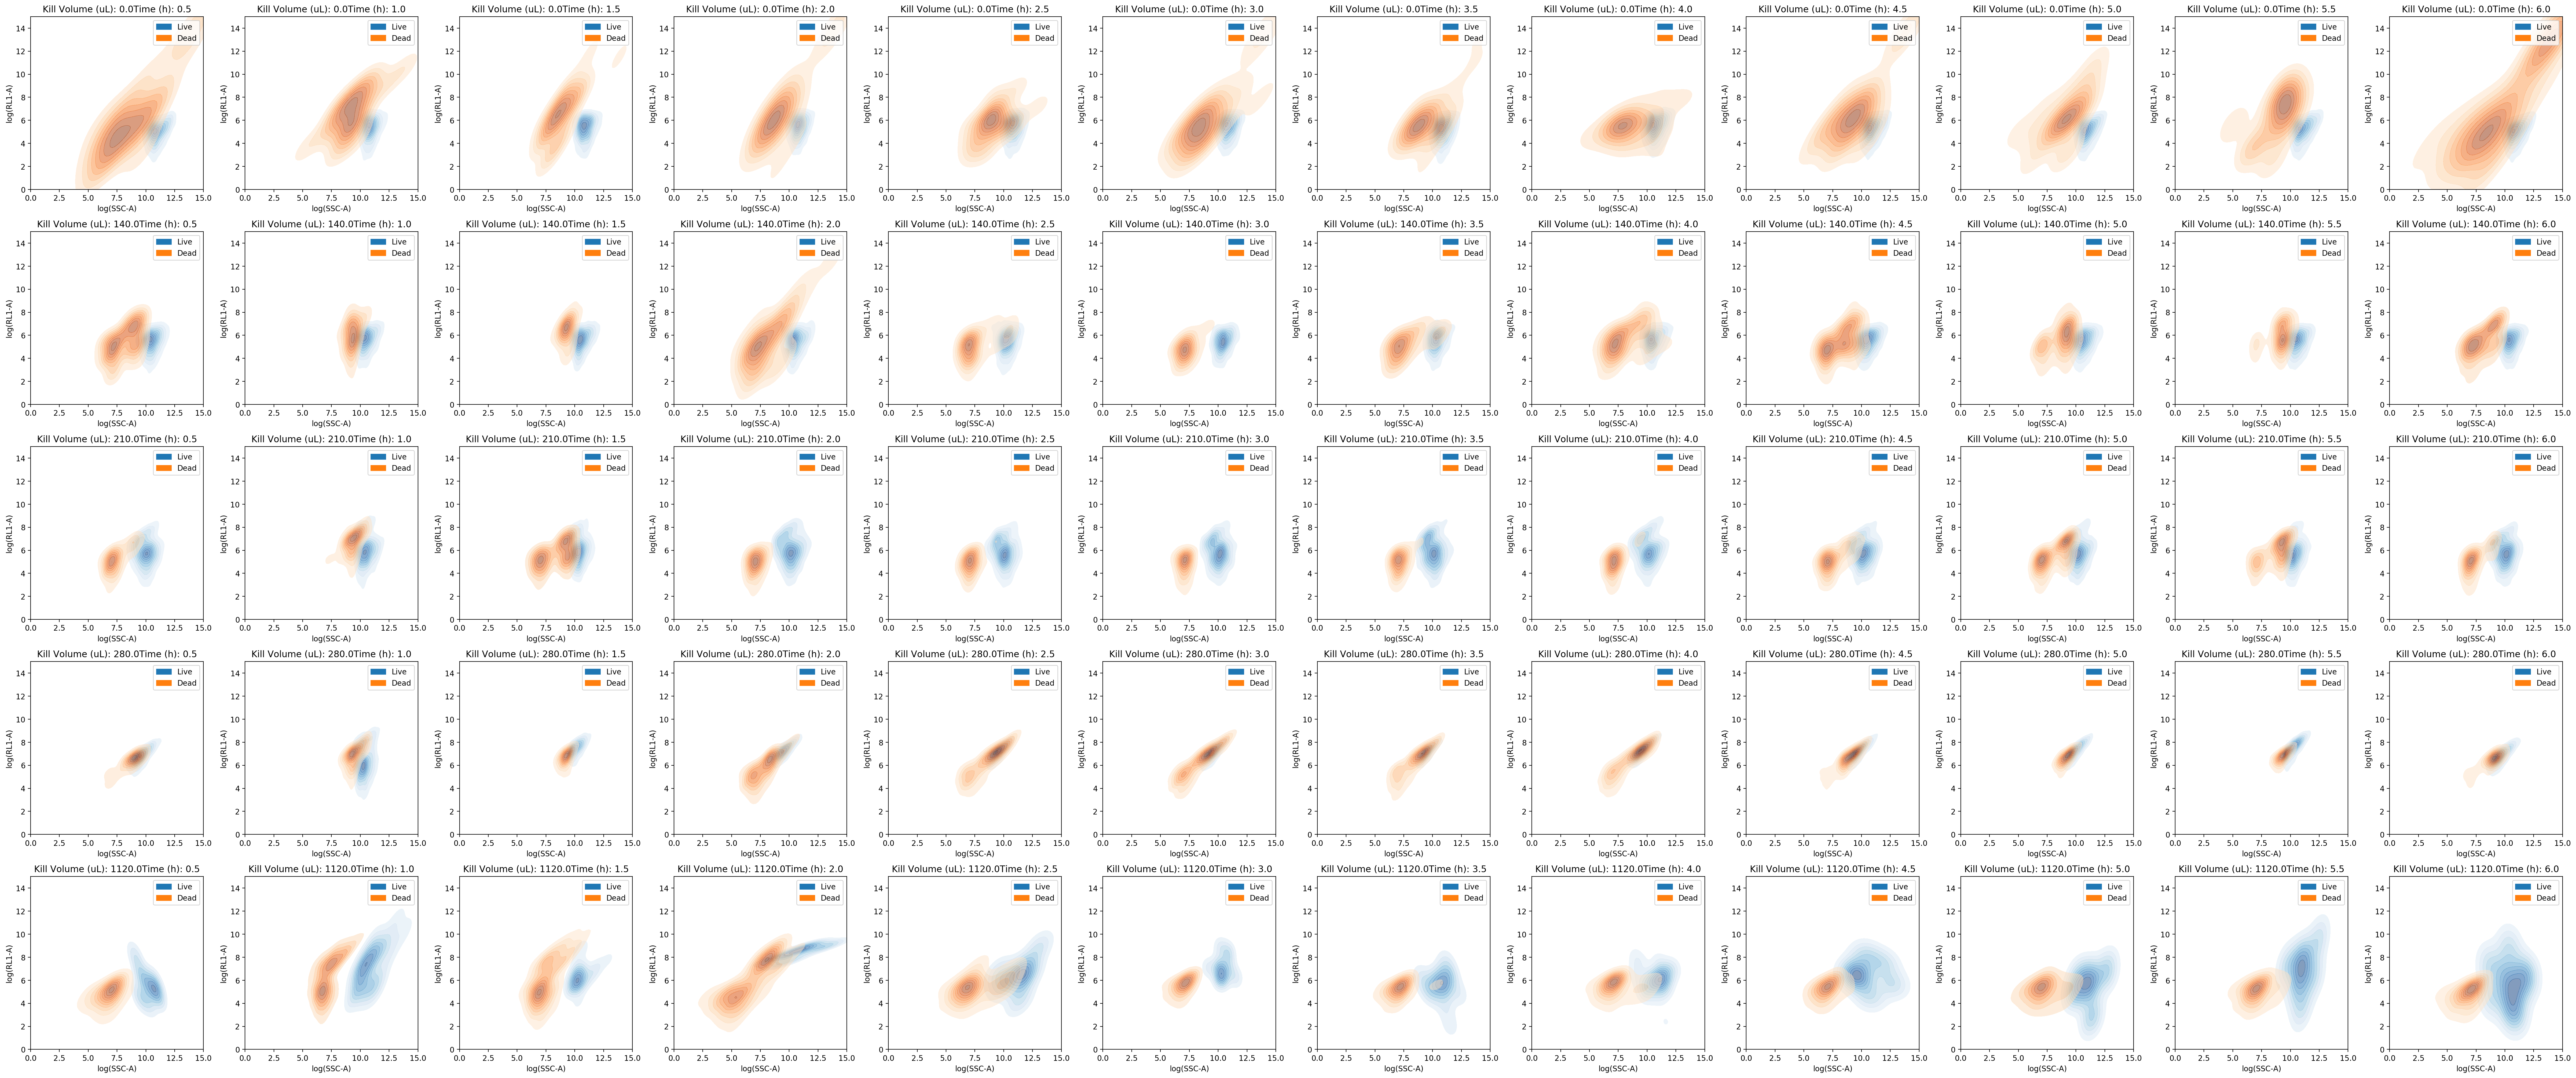

In [16]:
## Plot the time series channels with predictions

prediction_files = glob.glob('data/transcriptic/' + run_id + '/*/data.csv')
def get_time_point(pf):
    return int(pf.split("_")[-1].split('/')[0])
prediction_files = {get_time_point(p) : p for p in prediction_files}
time_points = list(prediction_files.keys())
time_points.sort()

xcol = 'SSC-A'
ycol = 'RL1-A'
stain = "SYTOX Red Stain"

df = pd.read_csv(prediction_files[1], index_col=0)
kill_volumes = list(df.kill_volume.dropna().unique())
kill_volumes.sort()


num_points = bldp.get_timeseries_scatter(xcol, ycol, stain, time_points, kill_volumes, prediction_files, flow_data, live_col='live', frac=0.1)





print(num_points)


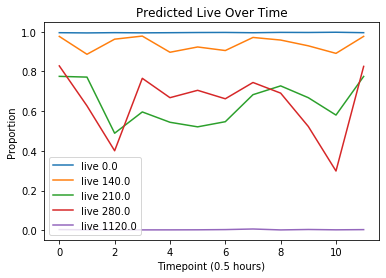

In [17]:
counts = num_points #{'dead': [409100, 406490, 407167, 405627, 405311, 412372, 437616, 454782, 449720, 457355, 457200, 447489], 'live': [70900, 73510, 72833, 74373, 74689, 67628, 42384, 25218, 30280, 22645, 22800, 32511]}

for volume in counts['live'].keys():
    for i in range(len(counts['live'][volume])):
        n = counts['dead'][volume][i] + counts['live'][volume][i]
        counts['dead'][volume][i] /= n
        counts['live'][volume][i] /= n

#plt.plot(counts['dead'], c='r', label='dead')
for volume in counts['live'].keys():
    plt.plot(counts['live'][volume],  label='live '+ str(volume))
plt.title("Predicted Live Over Time")
plt.xlabel("Timepoint (0.5 hours)")
plt.ylabel("Proportion")
plt.legend()

In [65]:
flow_data

Name DataType     Operation AnalysisTool                                                      Datasets  time_point  time                         container         container_name
4   Flow (Sytox) Plate 12_6.0 hour  file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x139998630>  12          6.0   Container(Flow (Sytox) Plate 12)  Flow (Sytox) Plate 12
5   Flow (Sytox) Plate 1_0.5 hour   file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1399abf28>  1           0.5   Container(Flow (Sytox) Plate 1)   Flow (Sytox) Plate 1 
6   Flow (Sytox) Plate 4_2.0 hour   file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1393d2fd0>  4           2.0   Container(Flow (Sytox) Plate 4)   Flow (Sytox) Plate 4 
7   Flow (Sytox) Plate 5_2.5 hour   file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x13994a898>  5           2.5   Container(Flow (Sytox) Plate 5)   Flow (Sytox) Plate 5 
8   Flow (Sytox) Plate 7_3.5 hour   file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1399984e0>  7           3.5   Container(Flow (Sytox) Plate 7)   Flow (Sytox) Plate 7 
9   Flow (Sytox) Plate 8_4.0 hour   file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1399c54a8>  8           4.0   Container(Flow (Sytox) Plate 8)   Flow (Sytox) Plate 8 
10  Flow (Sytox) Plate 9_4.5 hour   file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1399c5ba8>  9           4.5   Container(Flow (Sytox) Plate 9)   Flow (Sytox) Plate 9 
11  Flow (Sytox) Plate 11_5.5 hour  file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1399de3c8>  11          5.5   Container(Flow (Sytox) Plate 11)  Flow (Sytox) Plate 11
12  Flow (Sytox) Plate 2_1.0 hour   file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1399deac8>  2           1.0   Container(Flow (Sytox) Plate 2)   Flow (Sytox) Plate 2 
13  Flow (Sytox) Plate 3_1.5 hour   file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1399ed2e8>  3           1.5   Container(Flow (Sytox) Plate 3)   Flow (Sytox) Plate 3 
14  Flow (Sytox) Plate 6_3.0 hour   file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1399edfd0>  6           3.0   Container(Flow (Sytox) Plate 6)   Flow (Sytox) Plate 6 
15  Flow (Sytox) Plate 10_5.0 hour  file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x139a10208>  10          5.0   Container(Flow (Sytox) Plate 10)  Flow (Sytox) Plate 10

12    42
11    42
10    42
9     42
8     42
7     42
6     42
5     42
4     42
3     42
2     42
1     42
Name: time_point, dtype: int64


No handles with labels found to put in legend.


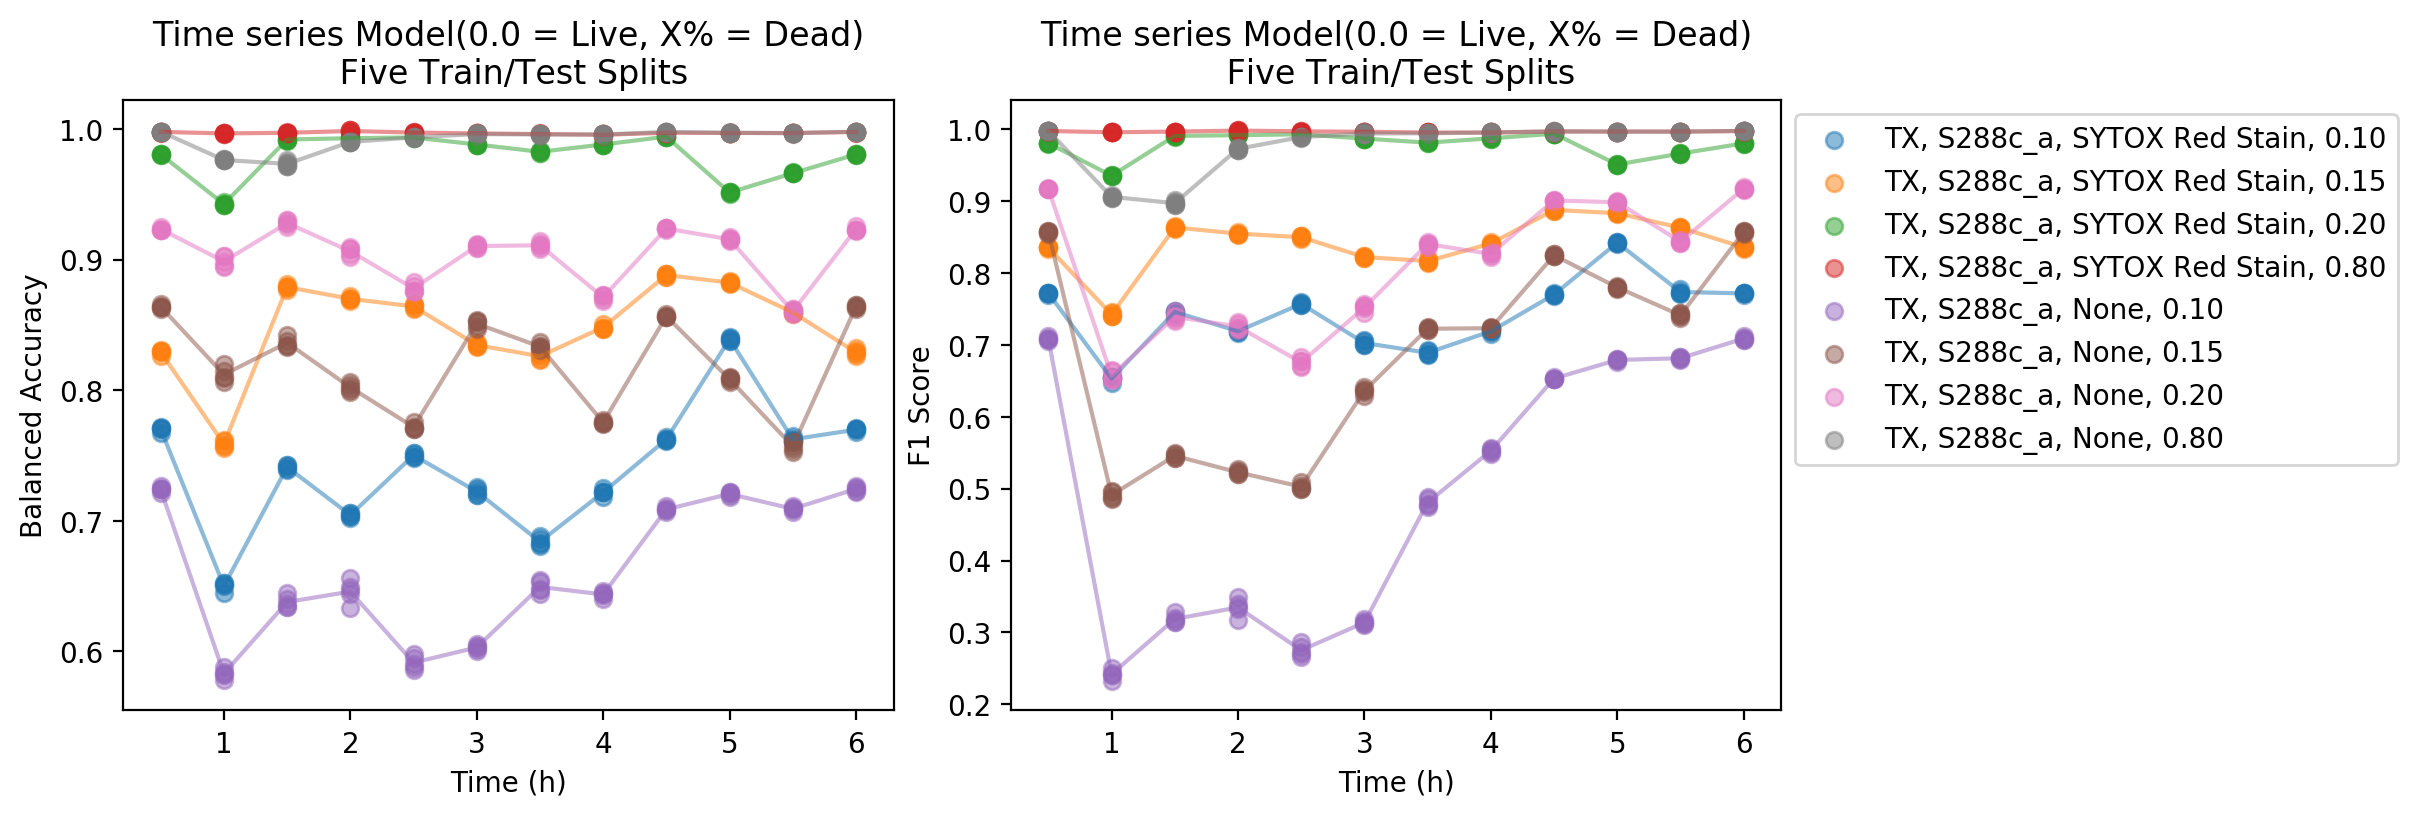

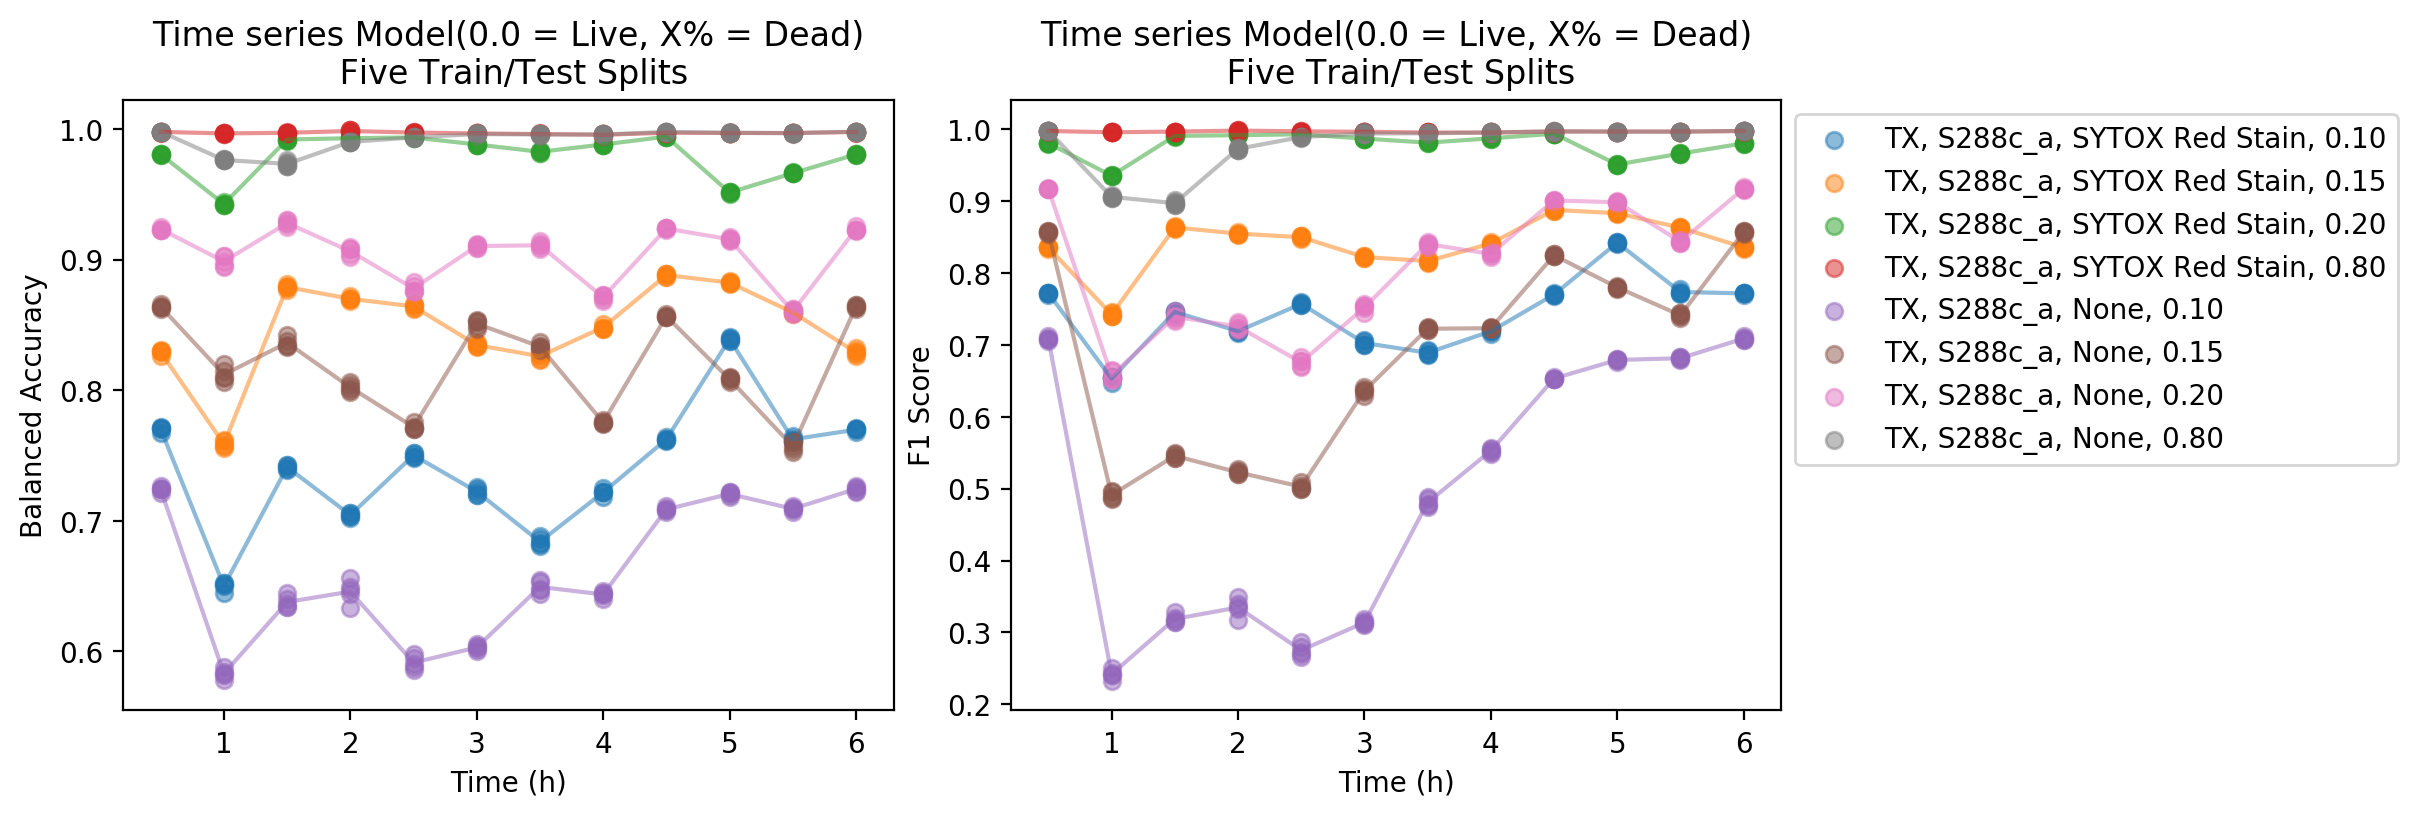

In [64]:
df = leader_board_df.loc[leader_board_df['Data and Split Description'].str.contains(run_id)]
df = df.dropna(subset=['time_point'])
df = df.astype({'time_point': 'int32'})
print(df.time_point.value_counts())
bldp.get_statistics_by_time(df.merge(flow_data, on='time_point'), experiment_strain=run_strain, experiment_lab=experiment_lab)


In [10]:
data_dir = os.path.join('data/transcriptic')
data_files = glob.glob(data_dir + '/' + run_id + '/*/data.csv')
#print(data_files)
channels=['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 
                                      'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W',
                                      'BL1-W', 'RL1-W']

mean_channel_df = pd.DataFrame()
for data_file in data_files:
    data_file_df = pd.read_csv(data_file, index_col=0)
    #print(data_file_df.head(1))
    data_file_df = data_file_df.fillna( 'None')
    for channel in channels:
        data_file_df.loc[:,channel] = data_file_df[channel].apply(np.log)
    data_file_df = data_file_df.replace([-np.inf, np.inf], np.nan)#.dropna(how="any")

    data_file_df = data_file_df.groupby(['kill_volume', 'stain']).agg([np.mean, np.std]).reset_index()
    time_point = int(data_file.split("_")[-1].split('/')[0])
    data_file_df['time_point'] = time_point
    mean_channel_df = mean_channel_df.append(data_file_df, ignore_index=True)
mean_channel_df
    


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


kill_volume            stain   Unnamed: 0.1                Unnamed: 0.1.1                Unnamed: 0.1.1.1                         Time                   FSC-A                SSC-A               BL1-A               RL1-A                FSC-H                SSC-H               BL1-H               RL1-H               FSC-W               SSC-W               BL1-W               RL1-W                    index                     live            live_210            live_280           time_point
                                           mean            std           mean            std             mean            std          mean          std       mean       std       mean       std      mean       std      mean       std       mean       std       mean       std      mean       std      mean       std      mean       std      mean       std      mean       std      mean       std           mean            std      mean       std      mean       std      mean       std           
0    0.0         None             221093.835859  110784.829435  221093.835859  110784.829435  462256.333897    344781.719638  10189.803663  4477.639482  11.114522  0.555676  11.850671  0.658172  3.932096  1.077681  4.452786  1.122624  10.949626  0.430908  11.685150  0.558626  4.300781  0.427641  4.818153  0.488425  3.638453  0.260934  3.913706  0.398719 NaN       NaN        5.567858  1.065426  221093.835859  110784.829435  0.995537  0.066655  0.892820  0.309345  0.940905  0.235805  7        
1    0.0         SYTOX Red Stain  695068.984293  146530.939406  695068.984293  146530.939406  491027.474531    186369.087279  5011.030601   3383.421970  11.144473  0.582646  11.862433  0.698339  3.970500  1.092405  4.882898  1.173790  10.915206  0.377514  11.639687  0.553106  4.246766  0.431519  5.241368  0.584547  3.698649  0.386767  3.958705  0.473611 NaN       NaN        5.594298  1.073741  695068.984293  146530.939406  0.995732  0.065189  0.897828  0.302876  0.985048  0.121361  7        
2    140.0       None             273948.250000  148801.626478  273948.250000  148801.626478  581671.500000    408541.880050  6135.933058   2704.110358  11.018537  0.525528  11.574563  0.696050  3.954428  1.069352  4.425742  1.073260  10.863899  0.379550  11.416325  0.594852  4.284109  0.423794  4.789419  0.460000  3.603772  0.306985  3.790153  0.393066 NaN       NaN        5.777020  0.949192  273948.250000  148801.626478  0.973075  0.161865  0.566258  0.495592  0.686392  0.463961  7        
3    140.0       SYTOX Red Stain  824837.324735  158304.000032  824837.324735  158304.000032  678498.590645    205646.305982  5253.848216   3389.392529  11.040587  0.537375  11.584144  0.706368  3.961853  1.060868  5.140379  1.326618  10.875919  0.380844  11.417837  0.595702  4.271003  0.416804  5.359385  0.759514  3.617996  0.324984  3.801554  0.409177 NaN       NaN        5.556343  1.385732  824837.324735  158304.000032  0.984139  0.124939  0.707108  0.455092  0.887145  0.316417  7        
4    210.0       None             230687.664819  140872.908550  230687.664819  140872.908550  510612.185423    387647.924185  7359.448774   3846.154984  10.828980  0.658916  11.029898  0.805905  4.019705  1.082675  4.457700  1.077725  10.692965  0.536453  10.887260  0.710958  4.315548  0.435455  4.811882  0.482609  3.531804  0.341868  3.590774  0.410141 NaN       NaN        5.872091  0.903769  230687.664819  140872.908550  0.902792  0.296242  0.156208  0.363054  0.265349  0.441521  7        
..     ...                   ...            ...            ...            ...            ...            ...              ...          ...           ...        ...       ...        ...       ...       ...       ...       ...       ...        ...       ...        ...       ...       ...       ...       ...       ...       ...       ...       ...       ...  ..        ..             ...       ...            ...            ...       ...       ...       ...       ...       ...       ... ..        
115  210.0       SYTOX Red S

['None' 'SYTOX Red Stain']


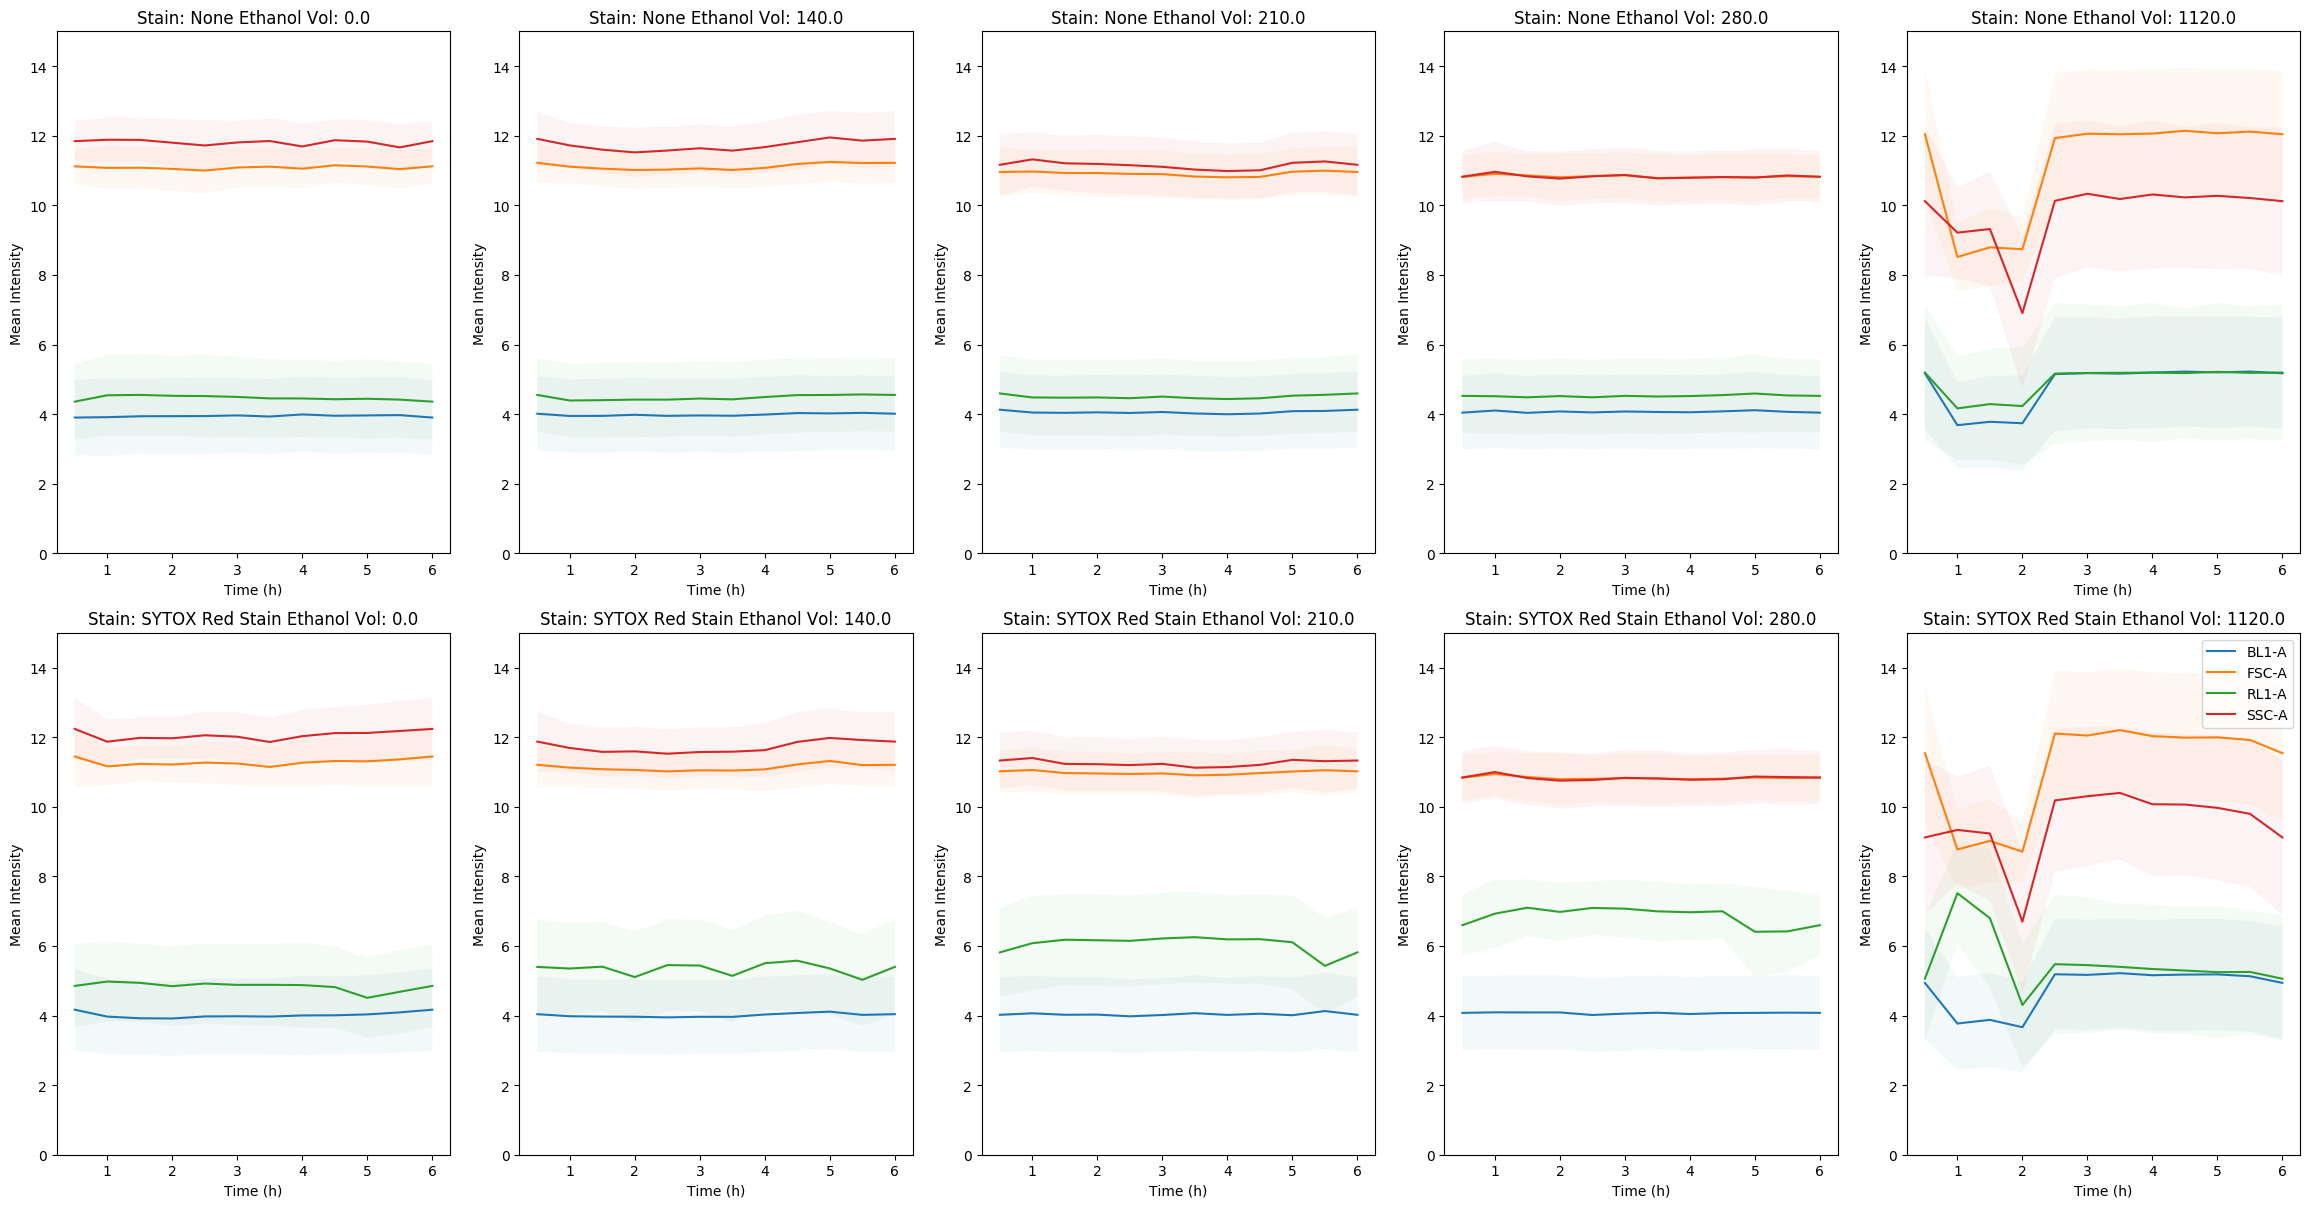

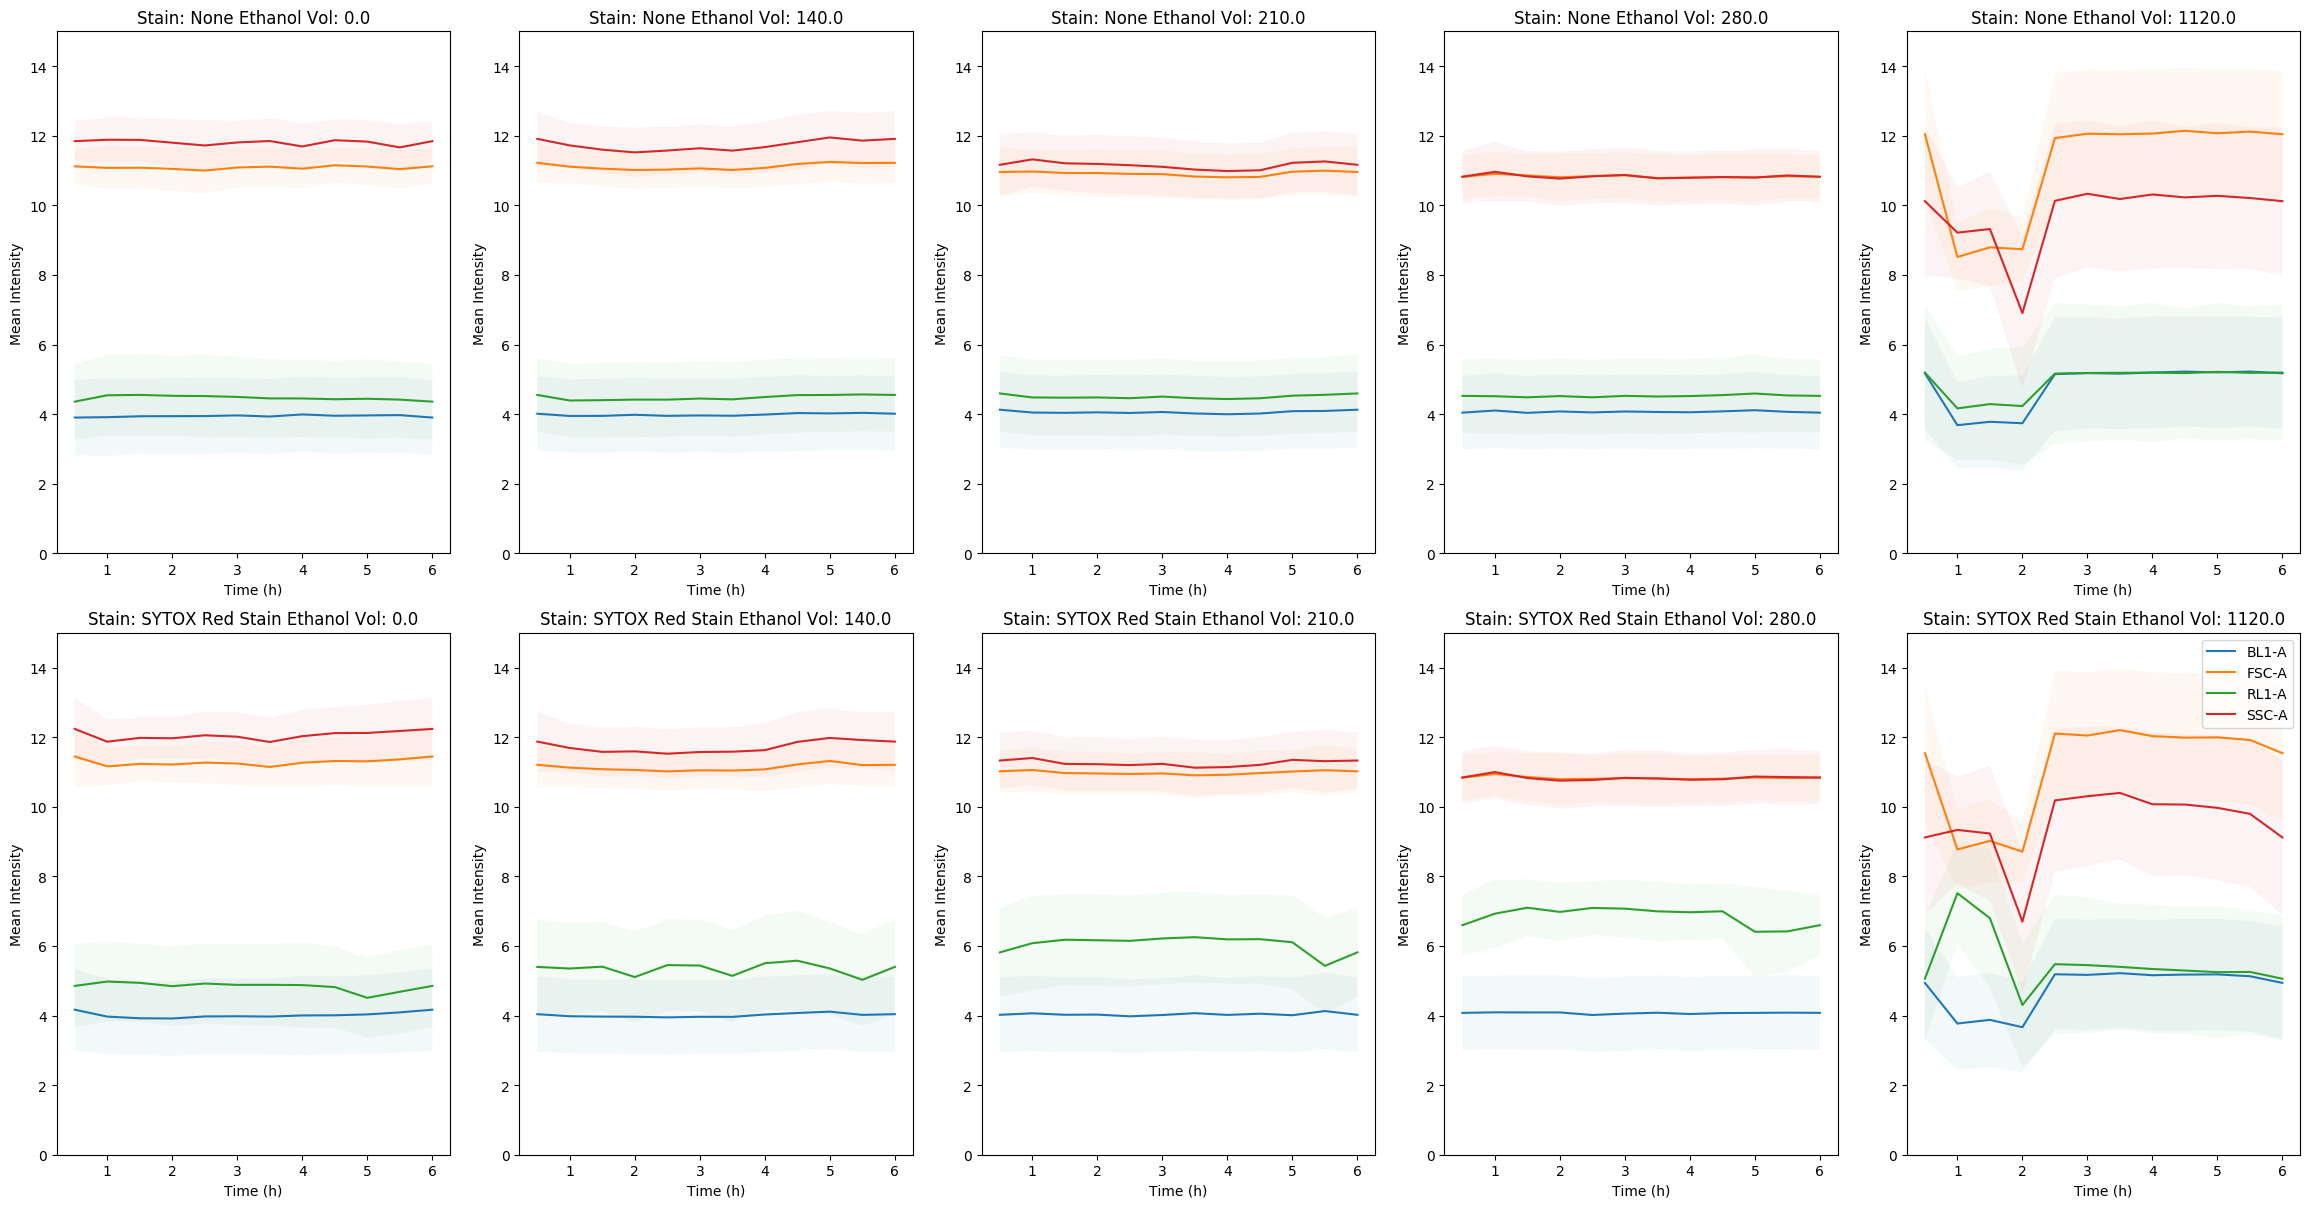

In [11]:
mean_channel_df1 = mean_channel_df.merge(flow_data, how='left', on='time_point')

channels=['FSC-A', 'SSC-A', 'RL1-A', 'BL1-A']
#channels=['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 
#                                      'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W',
#                                      'BL1-W', 'RL1-W']

bldp.get_channel_mean_timeseries(mean_channel_df1, 
                               channels=channels
                               )

In [4]:
leader_board_df = blda.get_leader_board_df('.', expand_description=True)
#leader_board_df.loc[leader_board_df['stain'].isna()]
bldp.get_statistics_by_volume(leader_board_df, experiment_strain=run_strain, experiment_lab=experiment_lab)

NameError: name 'bldp' is not defined

(<Figure size 1600x800 with 2 Axes>, mean    0.011648
 std     0.018305
 dtype: float64)

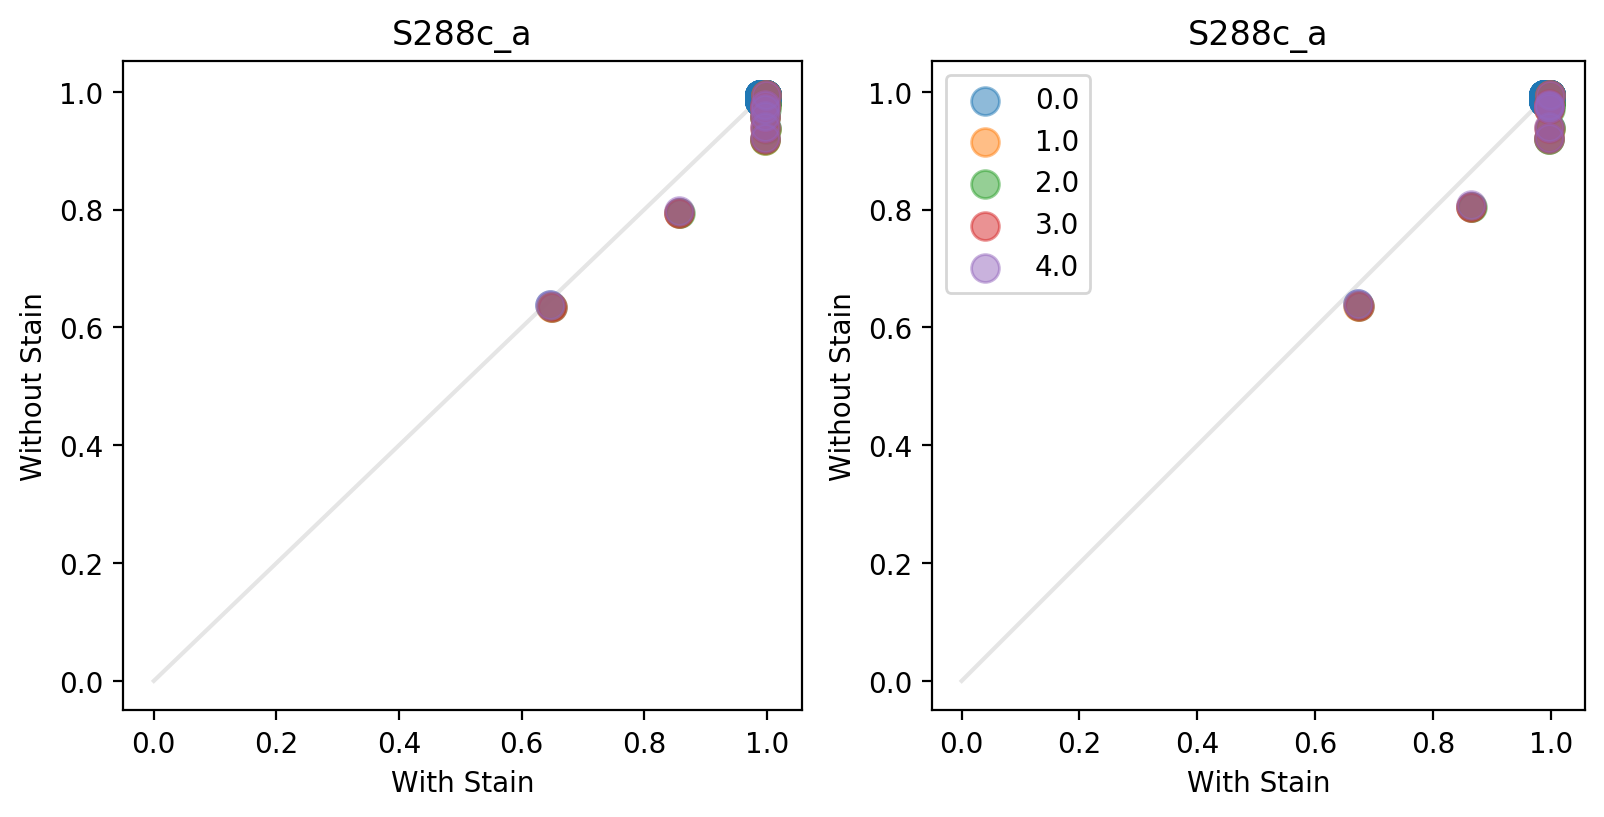

In [182]:
leader_board_df = blda.get_leader_board_df('.', expand_description=True)
bldp.get_stain_scatter(leader_board_df, experiments[2], experiment_strain=run_strain)

Index(['Container Type', 'Control', 'Culture_Volume', 'Media', 'Replicate', 'Storage (C)', 'Strain', 'checksum', 'filename', 'kill', 'kill_volume', 'plate_id', 'source', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live', 'live_ss'], dtype='object')


Text(0.5, 0, 'Ethanol %')

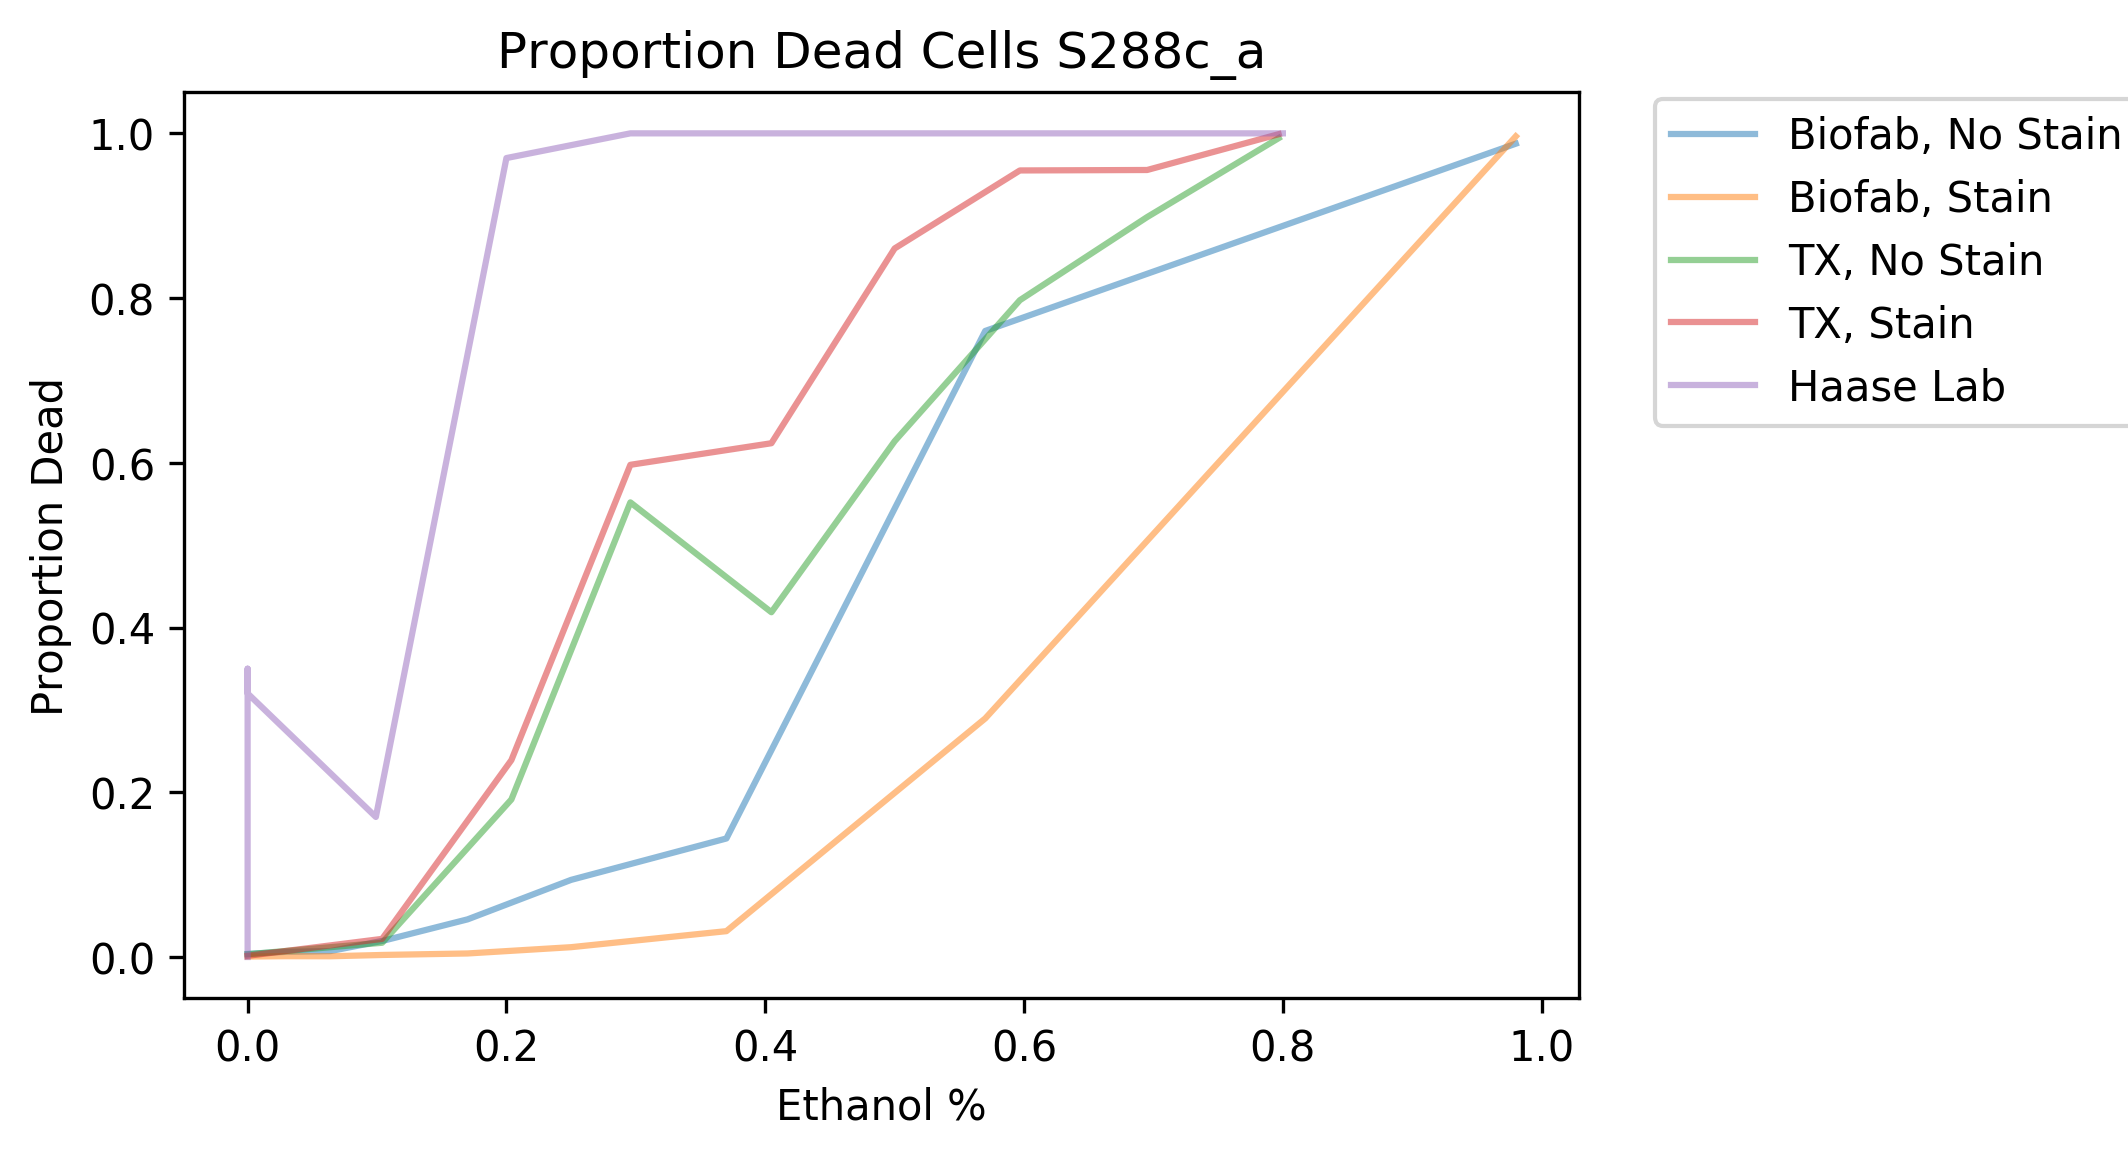

In [199]:
# For each sample, what proportion are dead?

robs_experiment = pd.read_csv('../resources/6-12_percent_dead.csv')

data_dir = os.path.join('data/biofab', experiments[1])
all_data_file = os.path.join(data_dir, 'data.csv')
experiment_df = pd.read_csv(all_data_file, index_col=0)


data_dir1 = os.path.join('data/transcriptic')
all_data_file1 = os.path.join(data_dir1, 'data.csv')
experiment_df1 = pd.read_csv(all_data_file1, index_col=0)
print(experiment_df1.columns)

#dead_proportion = experiment_df.where((pd.notnull(experiment_df)), "None").groupby(['kill_volume', 'sample_id', 'stain'])['live'].agg(lambda x: 1 - x.mean()).groupby(['kill_volume', 'stain']).agg(np.mean).reset_index().rename(columns={'live' : 'dead'})
dead_proportion = experiment_df.where((pd.notnull(experiment_df)), "None").groupby(['kill_volume',  'stain'])['live'].agg(lambda x: 1 - x.mean()).reset_index().rename(columns={'live' : 'dead'})
dead_proportion = dead_proportion.loc[dead_proportion.kill_volume != "None"]
#dead_proportion_ss = experiment_df.where((pd.notnull(experiment_df)), "None").groupby(['kill_volume', 'sample_id', 'stain'])['live_ss'].agg(lambda x: 1 - x.mean()).groupby(['kill_volume', 'stain']).agg(np.mean).reset_index().rename(columns={'live_ss' : 'dead_ss'})
dead_proportion_ss = experiment_df.where((pd.notnull(experiment_df)), "None").groupby(['kill_volume', 'stain'])['live_ss'].agg(lambda x: 1 - x.mean()).reset_index().rename(columns={'live_ss' : 'dead_ss'})
dead_proportion_ss = dead_proportion_ss.loc[dead_proportion_ss.kill_volume != "None"]


#dead_proportion1 = experiment_df1.where((pd.notnull(experiment_df1)), "None").groupby(['kill_volume', 'well', 'stain'])['live'].agg(lambda x: 1 - x.mean()).groupby(['kill_volume', 'stain']).agg(np.mean).reset_index().rename(columns={'live' : 'dead'})
dead_proportion1 = experiment_df1.where((pd.notnull(experiment_df1)), "None").groupby(['kill_volume', 'stain'])['live'].agg(lambda x: 1 - x.mean()).reset_index().rename(columns={'live' : 'dead'})
dead_proportion1 = dead_proportion1.loc[dead_proportion1.kill_volume != "None"]
dead_proportion1_ss = experiment_df1.where((pd.notnull(experiment_df1)), "None").groupby(['kill_volume', 'stain'])['live_ss'].agg(lambda x: 1 - x.mean()).reset_index().rename(columns={'live_ss' : 'dead_ss'})
dead_proportion1_ss = dead_proportion1_ss.loc[dead_proportion1_ss.kill_volume != "None"]



#experiment_id = experiment_df.experiment_id.dropna().unique()[0]
experiment_id = experiment_df.strain.dropna().unique()[0]
#print(dead_proportion)
fig = plt.figure(dpi=300)
ax = plt.subplot(111)
percentages=[ 100*x for x in [0, .03, .06, .10, .15, .20, .27, .36, .49]]

df=dead_proportion.loc[dead_proportion.stain == "None"]
ax.plot(df['kill_volume']/1000, df['dead'], label="Biofab, No Stain", alpha=0.5)
df=dead_proportion.loc[dead_proportion.stain == "SYTOX Red Stain"]
ax.plot(df['kill_volume']/1000, df['dead'], label="Biofab, Stain", alpha=0.5)
#df=dead_proportion_ss.loc[dead_proportion_ss.stain == "None"]
#ax.plot(df['kill_volume']/1000, df['dead_ss'], label="Biofab, No Stain, SS", alpha=0.5)
#df=dead_proportion_ss.loc[dead_proportion_ss.stain == "SYTOX Red Stain"]
#ax.plot(df['kill_volume']/1000, df['dead_ss'], label="Biofab, Stain, SS", alpha=0.5)


df=dead_proportion1.loc[dead_proportion1.stain == "None"]
ax.plot(df['kill_volume']/(df['kill_volume']+250), df['dead'], label="TX, No Stain", alpha=0.5)
df=dead_proportion1.loc[dead_proportion1.stain == "SYTOX Red Stain"]
ax.plot(df['kill_volume']/(df['kill_volume']+250), df['dead'], label="TX, Stain", alpha=0.5)
#df=dead_proportion1_ss.loc[dead_proportion1_ss.stain == "None"]
#ax.plot(df['kill_volume']/(df['kill_volume']+250), df['dead_ss'], label="TX, No Stain, SS", alpha=0.5)
#df=dead_proportion1_ss.loc[dead_proportion1_ss.stain == "SYTOX Red Stain"]
#ax.plot(df['kill_volume']/(df['kill_volume']+250), df['dead_ss'], label="TX, Stain, SS", alpha=0.5)


ax.plot(robs_experiment["Ethanol vol (ul)"]/(robs_experiment["Ethanol vol (ul)"]+robs_experiment["culture vol (ul)"]), 
        robs_experiment['% Dead'], label="Haase Lab", alpha=0.5)
#ax.bar()
#ax.set_xscale('log')
fig.legend(bbox_to_anchor=(1.2, 0.9))
plt.title("Proportion Dead Cells "  + experiment_id)
ax.set_ylabel("Proportion Dead")
ax.set_xlabel("Ethanol %")
#plt.xticks(range(0, len(volumes)), volumes)


Index(['Container Type', 'Control', 'Culture_Volume', 'Media', 'Replicate', 'Storage (C)', 'Strain', 'checksum', 'filename', 'kill', 'kill_volume', 'plate_id', 'source', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live', 'live_ss'], dtype='object')


Text(0.5, 0, 'Ethanol %')

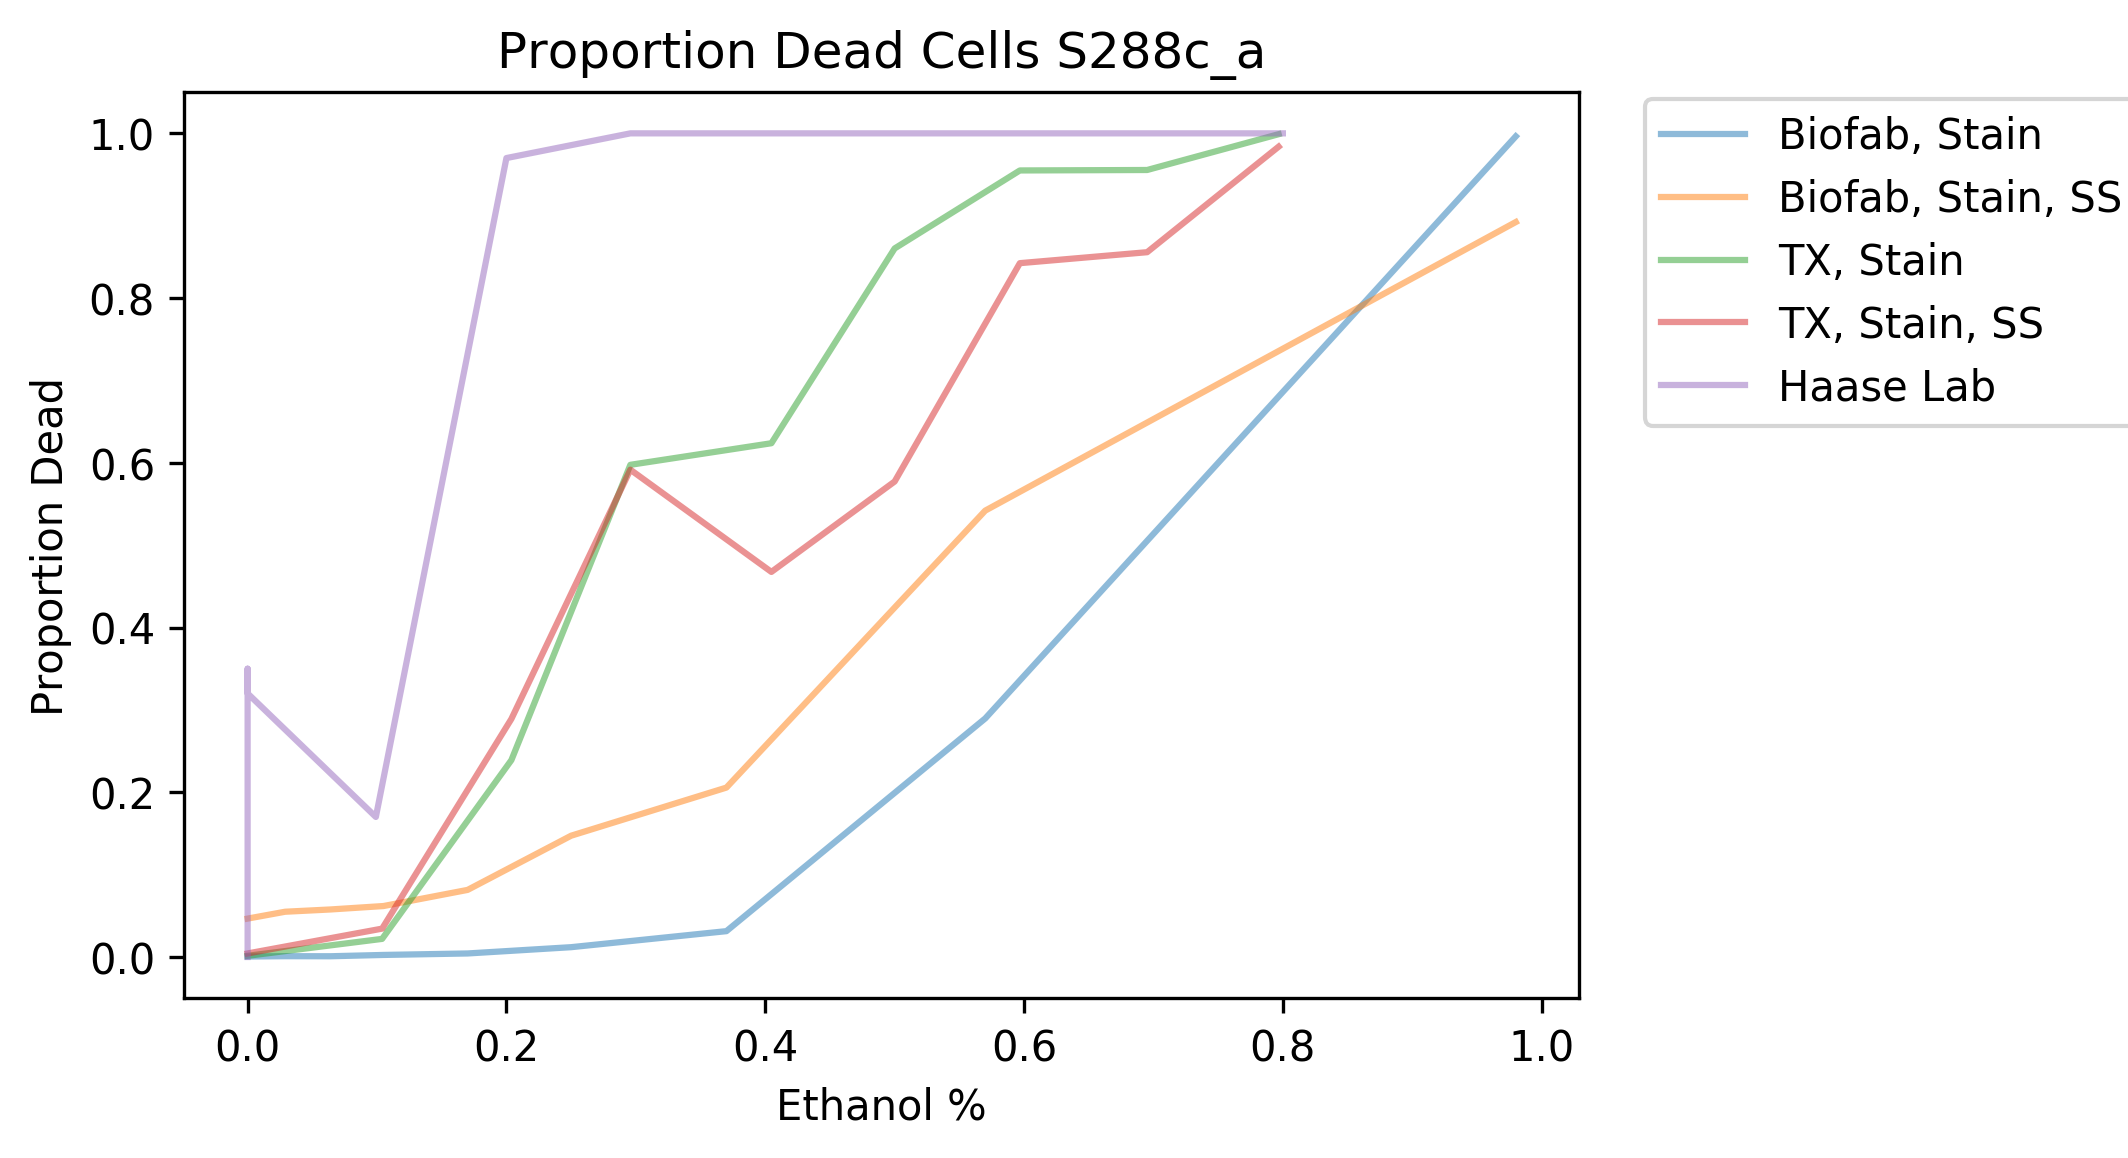

In [200]:
# For each sample, what proportion are dead?

robs_experiment = pd.read_csv('../resources/6-12_percent_dead.csv')

data_dir = os.path.join('data/biofab', experiments[1])
all_data_file = os.path.join(data_dir, 'data.csv')
experiment_df = pd.read_csv(all_data_file, index_col=0)


data_dir1 = os.path.join('data/transcriptic')
all_data_file1 = os.path.join(data_dir1, 'data.csv')
experiment_df1 = pd.read_csv(all_data_file1, index_col=0)
print(experiment_df1.columns)

#dead_proportion = experiment_df.where((pd.notnull(experiment_df)), "None").groupby(['kill_volume', 'sample_id', 'stain'])['live'].agg(lambda x: 1 - x.mean()).groupby(['kill_volume', 'stain']).agg(np.mean).reset_index().rename(columns={'live' : 'dead'})
dead_proportion = experiment_df.where((pd.notnull(experiment_df)), "None").groupby(['kill_volume',  'stain'])['live'].agg(lambda x: 1 - x.mean()).reset_index().rename(columns={'live' : 'dead'})
dead_proportion = dead_proportion.loc[dead_proportion.kill_volume != "None"]
#dead_proportion_ss = experiment_df.where((pd.notnull(experiment_df)), "None").groupby(['kill_volume', 'sample_id', 'stain'])['live_ss'].agg(lambda x: 1 - x.mean()).groupby(['kill_volume', 'stain']).agg(np.mean).reset_index().rename(columns={'live_ss' : 'dead_ss'})
dead_proportion_ss = experiment_df.where((pd.notnull(experiment_df)), "None").groupby(['kill_volume', 'stain'])['live_ss'].agg(lambda x: 1 - x.mean()).reset_index().rename(columns={'live_ss' : 'dead_ss'})
dead_proportion_ss = dead_proportion_ss.loc[dead_proportion_ss.kill_volume != "None"]


#dead_proportion1 = experiment_df1.where((pd.notnull(experiment_df1)), "None").groupby(['kill_volume', 'well', 'stain'])['live'].agg(lambda x: 1 - x.mean()).groupby(['kill_volume', 'stain']).agg(np.mean).reset_index().rename(columns={'live' : 'dead'})
dead_proportion1 = experiment_df1.where((pd.notnull(experiment_df1)), "None").groupby(['kill_volume', 'stain'])['live'].agg(lambda x: 1 - x.mean()).reset_index().rename(columns={'live' : 'dead'})
dead_proportion1 = dead_proportion1.loc[dead_proportion1.kill_volume != "None"]
dead_proportion1_ss = experiment_df1.where((pd.notnull(experiment_df1)), "None").groupby(['kill_volume', 'stain'])['live_ss'].agg(lambda x: 1 - x.mean()).reset_index().rename(columns={'live_ss' : 'dead_ss'})
dead_proportion1_ss = dead_proportion1_ss.loc[dead_proportion1_ss.kill_volume != "None"]



#experiment_id = experiment_df.experiment_id.dropna().unique()[0]
experiment_id = experiment_df.strain.dropna().unique()[0]
#print(dead_proportion)
fig = plt.figure(dpi=300)
ax = plt.subplot(111)
percentages=[ 100*x for x in [0, .03, .06, .10, .15, .20, .27, .36, .49]]

#df=dead_proportion.loc[dead_proportion.stain == "None"]
#ax.plot(df['kill_volume']/1000, df['dead'], label="Biofab, No Stain", alpha=0.5)
df=dead_proportion.loc[dead_proportion.stain == "SYTOX Red Stain"]
ax.plot(df['kill_volume']/1000, df['dead'], label="Biofab, Stain", alpha=0.5)
#df=dead_proportion_ss.loc[dead_proportion_ss.stain == "None"]
#ax.plot(df['kill_volume']/1000, df['dead_ss'], label="Biofab, No Stain, SS", alpha=0.5)
df=dead_proportion_ss.loc[dead_proportion_ss.stain == "SYTOX Red Stain"]
ax.plot(df['kill_volume']/1000, df['dead_ss'], label="Biofab, Stain, SS", alpha=0.5)


#df=dead_proportion1.loc[dead_proportion1.stain == "None"]
#ax.plot(df['kill_volume']/(df['kill_volume']+250), df['dead'], label="TX, No Stain", alpha=0.5)
df=dead_proportion1.loc[dead_proportion1.stain == "SYTOX Red Stain"]
ax.plot(df['kill_volume']/(df['kill_volume']+250), df['dead'], label="TX, Stain", alpha=0.5)
#df=dead_proportion1_ss.loc[dead_proportion1_ss.stain == "None"]
#ax.plot(df['kill_volume']/(df['kill_volume']+250), df['dead_ss'], label="TX, No Stain, SS", alpha=0.5)
df=dead_proportion1_ss.loc[dead_proportion1_ss.stain == "SYTOX Red Stain"]
ax.plot(df['kill_volume']/(df['kill_volume']+250), df['dead_ss'], label="TX, Stain, SS", alpha=0.5)


ax.plot(robs_experiment["Ethanol vol (ul)"]/(robs_experiment["Ethanol vol (ul)"]+robs_experiment["culture vol (ul)"]), 
        robs_experiment['% Dead'], label="Haase Lab", alpha=0.5)
#ax.bar()
#ax.set_xscale('log')
fig.legend(bbox_to_anchor=(1.2, 0.9))
plt.title("Proportion Dead Cells "  + experiment_id)
ax.set_ylabel("Proportion Dead")
ax.set_xlabel("Ethanol %")
#plt.xticks(range(0, len(volumes)), volumes)


In [162]:
dead_proportion['kill_volume'].unique()

array([0.0, 29.0, 64.0, 105.0, 170.0, 250.0, 370.0, 570.0, 980.0],
      dtype=object)

In [155]:
dead_proportion1['kill_volume']/(dead_proportion1['kill_volume']+1000)

0     0        
1     0        
2     0.0281827
3     0.0281827
4     0.0601504
5     0.0601504
6     0.0950226
7     0.0950226
8     0.145299 
9     0.145299 
10    0.2      
11    0.2      
12    0.270073 
13    0.270073 
14    0.363057 
15    0.363057 
16    0.494949 
17    0.494949 
Name: kill_volume, dtype: object

In [112]:
robs_experiment

Treatment  % Dead  culture vol (ul)  Ethanol vol (ul)  % Ethanol
0   Control 1    0.00    1000              0                 0.0      
1   Control 2    0.35    1000              0                 0.0      
2   Control 3    0.32    1000              0                 0.0      
3   10% Ethanol  0.17    1000              110               0.1      
4   20% Ethanol  0.97    1000              250               0.2      
5   30% Ethanol  1.00    1000              420               0.3      
6   40% Ethanol  1.00    1000              680               0.4      
7   50% Ethanol  1.00    1000              1000              0.5      
8   60% Ethanol  1.00    1000              1500              0.6      
9   70% Ethanol  1.00    1000              2300              0.7      
10  80% Ethanol  1.00    1000              4000              0.8

In [123]:
df = experiment_df.loc[experiment_df['stain'].isna()].groupby(['kill_volume']).agg(np.mean).reset_index()

#df = df.loc[df['live'] == 1]
df

kill_volume  level  stain_volume  temperature         FSC-A         SSC-A        FL1-A        FL2-A        FL3-A       FL4-A         FSC-H         SSC-H        FL1-H        FL2-H        FL3-H        FL4-H      Width         Time         index      live
0  0.0          0.0   NaN            30.0         1.286958e+06  1.346926e+05  1034.457842  409.249025   817.285917   484.002983  1.514119e+06  1.588075e+05  1102.681267  417.542842   1269.059825  1046.516600  55.733767  166.176275   1.681295e+06  0.996225
1  29.0         0.0   NaN            30.0         1.283254e+06  1.350910e+05  1100.840575  429.722700   830.089258   482.576242  1.511980e+06  1.602445e+05  1131.949533  425.528267   1267.778275  1037.558133  55.420317  172.123733   1.651295e+06  0.993825
2  64.0         0.0   NaN            30.0         1.327215e+06  1.396662e+05  1155.489992  450.612192   845.800992   477.385867  1.573616e+06  1.672782e+05  1156.600600  431.930358   1261.812567  1020.837942  55.454492  180.282150   1.621295e+06  0.992908
3  105.0        0.0   NaN            30.0         1.210569e+06  1.187208e+05  1357.343375  536.261992   909.310733   446.509117  1.520150e+06  1.479912e+05  1196.947225  450.858317   1205.484242  915.252608   52.569433  200.472917   1.591295e+06  0.980442
4  170.0        0.0   NaN            30.0         1.129597e+06  1.105586e+05  1688.059867  660.114983   1058.230917  435.610025  1.454739e+06  1.428065e+05  1347.158267  505.103033   1233.973692  856.343450   50.849417  213.475350   1.561295e+06  0.954908
5  250.0        0.0   NaN            30.0         1.102304e+06  1.224289e+05  1778.637417  746.022500   1270.381408  428.945992  1.453162e+06  1.640119e+05  1374.540433  545.722125   1312.070092  816.487292   49.521858  224.883983   1.531295e+06  0.906800
6  370.0        0.0   NaN            30.0         1.204099e+06  1.498971e+05  2058.188600  832.691267   1410.405200  423.631517  1.533997e+06  1.970778e+05  1446.702367  565.731750   1317.636283  757.163508   51.483933  288.179533   1.501295e+06  0.856575
7  570.0        0.0   NaN            30.0         5.601816e+05  5.962937e+04  1528.297278  663.694736   1087.972940  377.015997  8.745471e+05  8.928961e+04  1339.074282  526.822553   1094.555739  598.788861   35.643375  1164.383878  1.472637e+06  0.240156
8  980.0        0.0   NaN            30.0         8.247590e+06  8.702108e+06  6137.294449  1982.232979  5057.568651  576.887095  3.113633e+06  3.605369e+06  4312.516738  1338.120727  2729.913705  606.483362   88.798888  1892.149048  1.653739e+06  0.012299

1    1750162
0    348498 
Name: live, dtype: int64
['SYTOX Red Stain' nan]
                                             agave_path         agave_system challenge_problem               experiment_id                experiment_reference                                                         experiment_reference_url file_type                                                                                     filename                                                                                     hpc_path                                                                      jupyter_path kill_method  kill_volume kill_volume_unit        lab  level measurement_type                                           sample_id            stain  stain_volume stain_volume_unit   strain         strain_lab_id                                   strain_sbh_uri  temperature      FSC-A      SSC-A     FL1-A    FL2-A    FL3-A    FL4-A      FSC-H      SSC-H    FL1-H    FL2-H    FL3-H   FL4-H  Width   Time  index

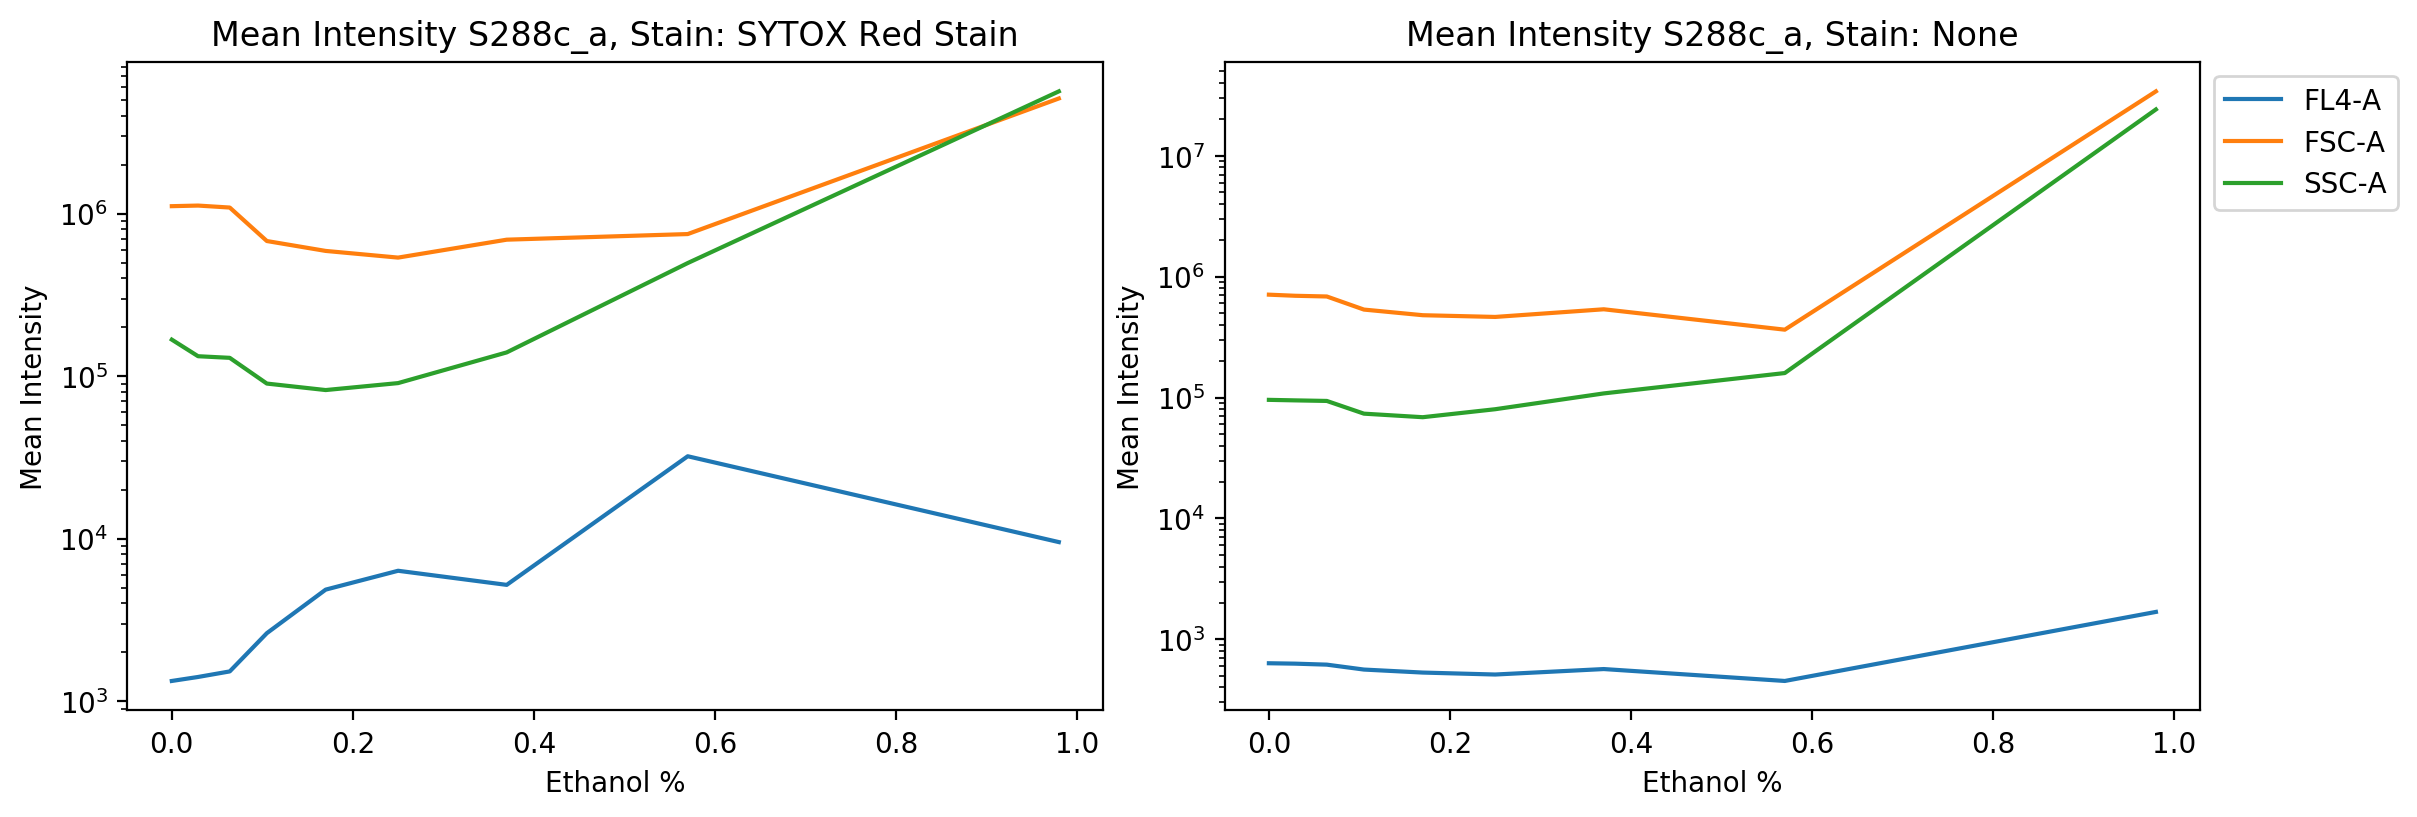

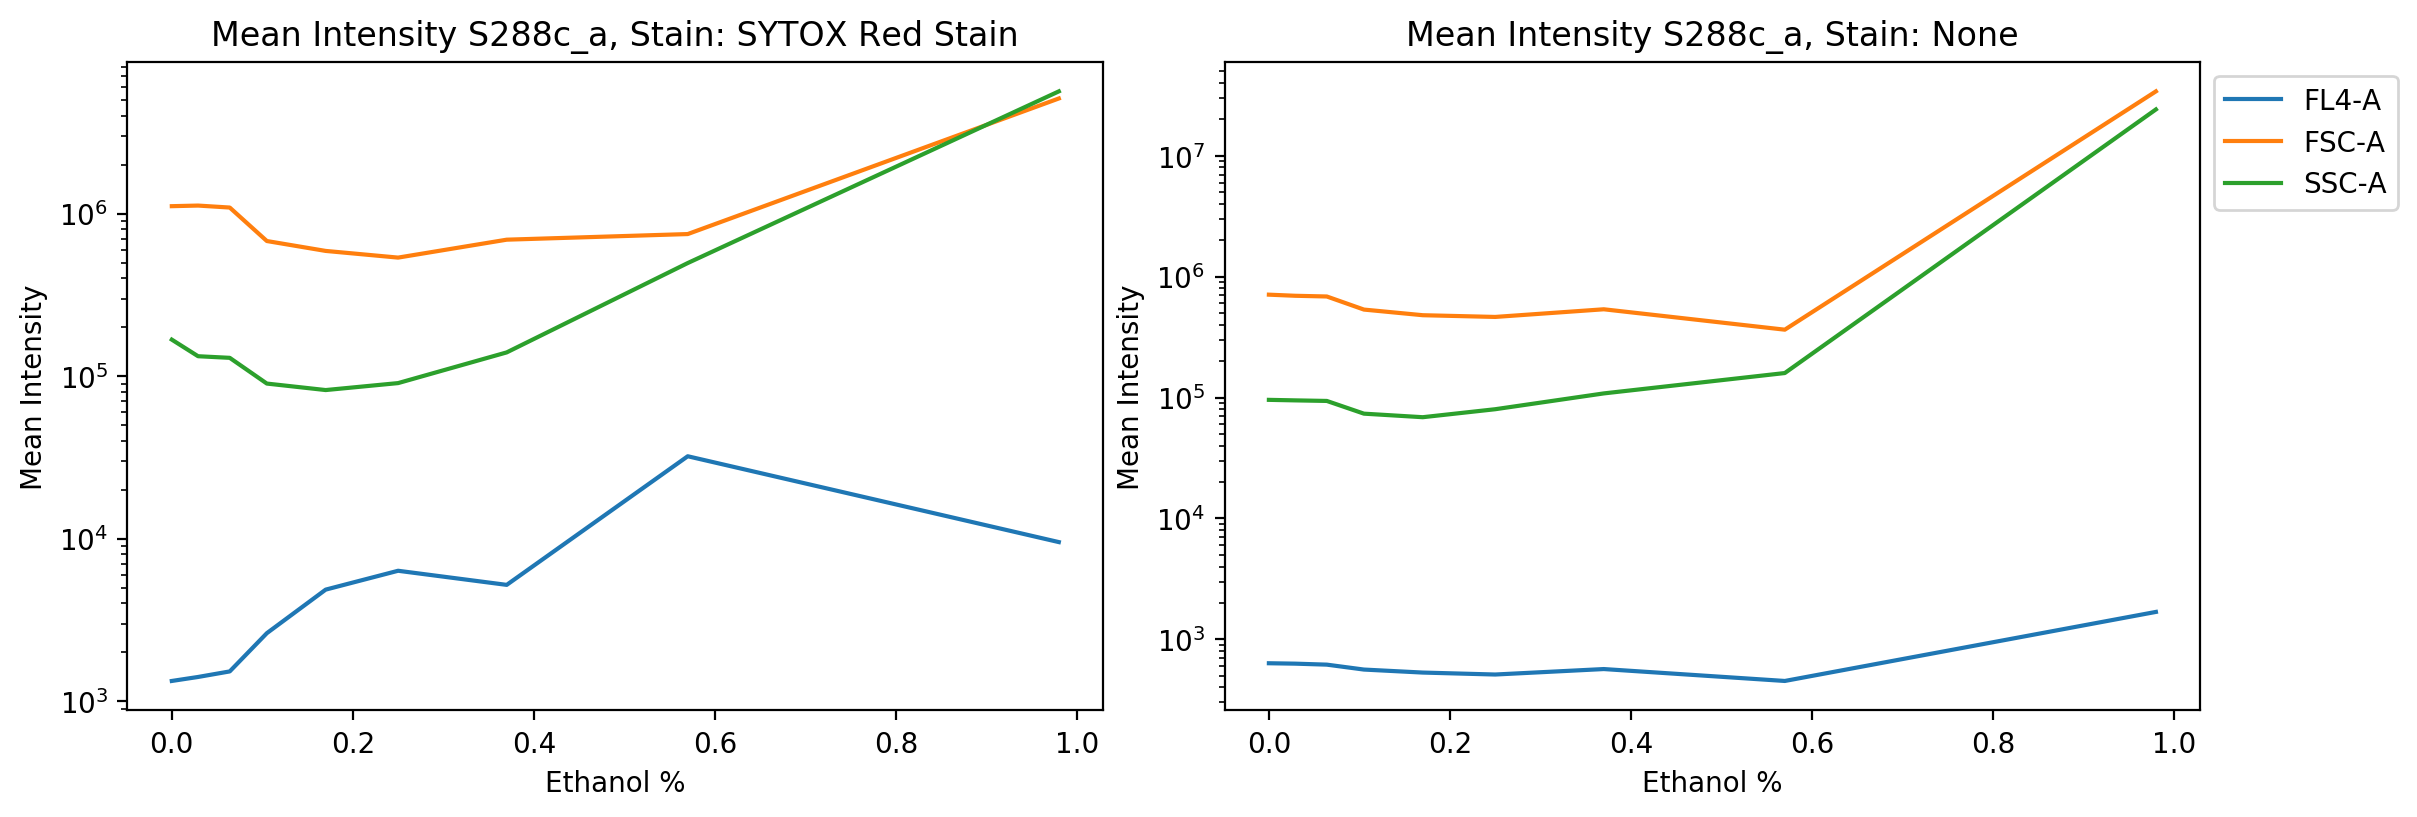

In [193]:
data_dir = os.path.join('data/biofab', experiments[1])
all_data_file = os.path.join(data_dir, 'data.csv')
experiment_df = pd.read_csv(all_data_file, index_col=0)
print(experiment_df.live.value_counts())
channels=['FSC-A', 'SSC-A', 'FL4-A']
bldp.get_channel_mean_titration(experiment_df, only_live=False, channels=channels,stat=np.std)

['SYTOX Red Stain' nan]
  Container Type Control                  Culture_Volume                                                                                                                                                              Media Replicate Storage (C)                                                                                                                                                           Strain                                  checksum                                                                                    filename     kill  kill_volume  plate_id            source            stain well   experiment_id  Time      FSC-A      SSC-A   BL1-A    RL1-A    FSC-H     SSC-H  BL1-H    RL1-H   FSC-W   SSC-W  BL1-W  RL1-W  index  live  live_ss
0  96-pcr         {}      {'qty': 1000.0, 'units': 'uL'}  {'YPAD': {'item_id': 378596, 'item_concentration': None, 'final_concentration': None, 'dilution_factor': None, 'working_volume': {'qty': 1000.0, 'units': 'µl'}}}

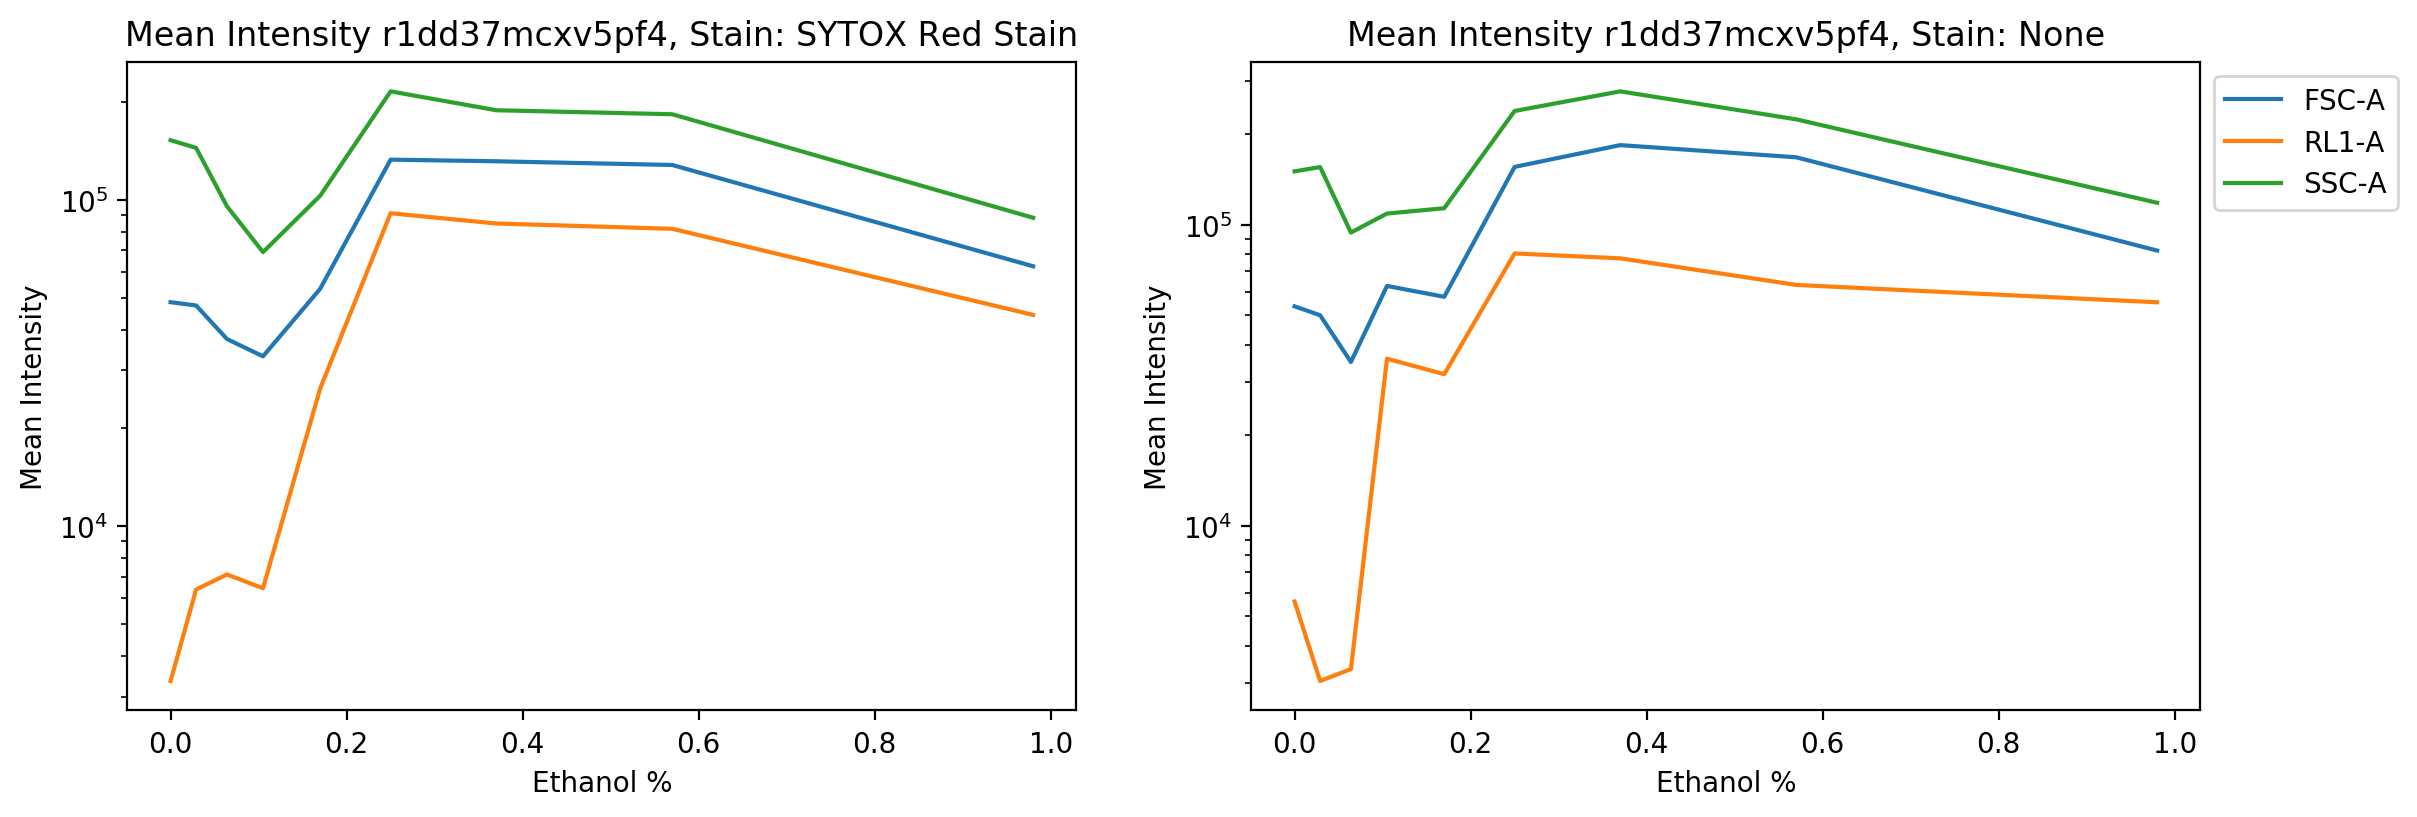

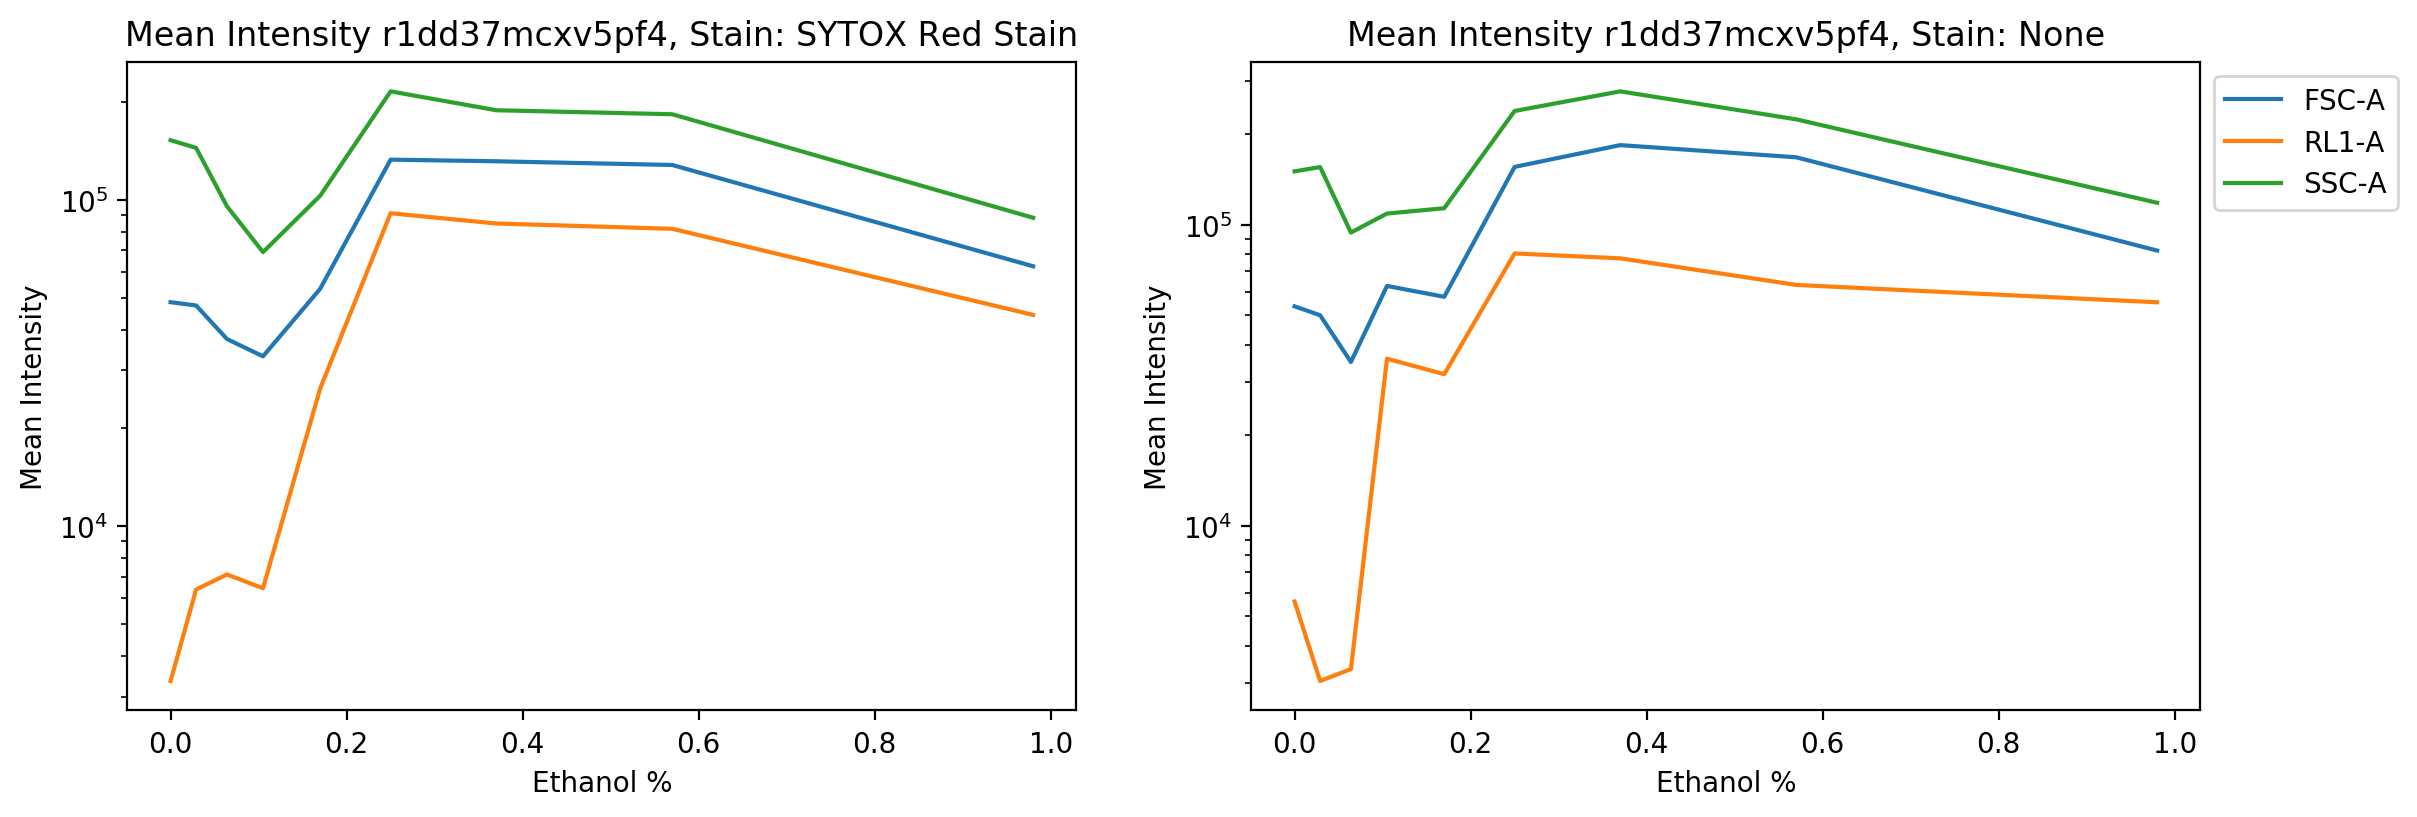

In [194]:
data_dir = os.path.join('data/transcriptic')
all_data_file = os.path.join(data_dir, 'data.csv')
experiment_df = pd.read_csv(all_data_file, index_col=0)


channels=['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 
                                      'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W',
                                      'BL1-W', 'RL1-W']
channels=['FSC-A', 'SSC-A', 'RL1-A']
bldp.get_channel_mean_titration(experiment_df, 
                               channels=channels,
                                stat=np.std
                               )

In [128]:
data_dir = os.path.join('data/biofab', experiments[1])
all_data_file = os.path.join(data_dir, 'data.csv')
experiment_df = pd.read_csv(all_data_file, index_col=0)

bldp.get_channel_histograms(experiment_df)

[autoreload of pysd2cat.plot.biofab_live_dead_plots failed: Traceback (most recent call last):
  File "/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen im

In [111]:
data_dir = os.path.join('data/transcriptic')
all_data_file = os.path.join(data_dir, 'data.csv')
experiment_df = pd.read_csv(all_data_file, index_col=0)

#bldp.get_channel_mean_titration(experiment_df)
bldp.get_channel_histograms(experiment_df, 
                               channels=['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 
                                      'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W',
                                      'BL1-W', 'RL1-W'])

In [159]:
all=experiment_df.loc[experiment_df['kill_volume'] == 250.0]['FL1-A'].sum()
live=experiment_df.loc[(experiment_df['kill_volume'] == 250.0) & (experiment_df['live'] == 1)]['FL1-A'].sum()
ratio = live/all
print(all)
print(live)
print(ratio)
print(experiment_df.loc[(experiment_df['kill_volume'] == 250.0)]['live'].mean())

407045863.0
376115824.0
0.9240133807722792
0.953375
